# Run

## Imports

In [1]:
! pip install mplfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.6 MB/s eta 0:00:00


In [2]:
# Ставим зависимости
!apt-get install -y build-essential
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib-0.4.0/
!./configure --prefix=/usr
!make
!make install
%cd ..
# Устанавливаем python-обертку
!pip install Ta-Lib
import talib

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
build-essential is already the newest version (12.9ubuntu3).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.
--2025-10-01 14:55:01--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 104.18.12.149, 104.18.13.149, 2606:4700::6812:d95, ...
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|104.18.12.149|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2025-10-01 14:55:02--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 104.18.13.149, 104.18.12.149, 2606:4700::6812:d95, ...
Reusing existing connection to prdownloads.sourceforge.n

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import mplfinance as mpf
import talib
import random
import datetime
import time
from tabulate import tabulate
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve

## Funcrions

### Get Binance klines

In [4]:
from datetime import timezone, datetime
import os
import requests
import zipfile
import csv
import io
from dateutil.relativedelta import relativedelta

def generate_months(start_date, end_date):
    start_date = datetime.strptime(start_date, '%Y-%m')
    end_date = datetime.strptime(end_date, '%Y-%m')
    months = []

    while start_date <= end_date:
        months.append(start_date.strftime('%Y-%m'))
        start_date = start_date + relativedelta(months=1)

    return months


# Загрузка данных с Binance
def download_klines(symbol, interval, start_date, end_date):
    months = generate_months(start_date, end_date)
    if not os.path.exists('klines'):
        os.mkdir('klines')

    klines = {
        'Date': [], 'Open': [], 'High': [], 'Low': [], 'Close': [], 'Volume': []
    }

    for month in months:
        filename = f"{symbol}-{interval}-{month}.zip"
        file_path = f"klines/{filename}"

        if not os.path.exists(file_path) or os.path.getsize(file_path) == 0:
            url = f"https://data.binance.vision/data/futures/um/monthly/klines/{symbol}/{interval}/{filename}"
            try:
                r = requests.get(url, allow_redirects=True)
                with open(file_path, 'wb') as f:
                    f.write(r.content)
            except Exception as e:
                print(f"Ошибка загрузки файла {filename}: {e}. Пропускаем.")
                continue

        try:
            with zipfile.ZipFile(file_path, 'r') as zip_file:
                with zip_file.open(f"{symbol}-{interval}-{month}.csv", 'r') as csv_file:
                    csv_reader = csv.reader(io.TextIOWrapper(csv_file, 'utf-8'))
                    for row in csv_reader:
                        if row[0].isdigit():
                            klines['Date'].append(datetime.fromtimestamp(int(row[0]) / 1000, tz=timezone.utc))
                            klines['Open'].append(float(row[1]))
                            klines['High'].append(float(row[2]))
                            klines['Low'].append(float(row[3]))
                            klines['Close'].append(float(row[4]))
                            klines['Volume'].append(float(row[5]))
        except (zipfile.BadZipFile, KeyError):
            print(f"Ошибка: Файл {file_path} поврежден или не является ZIP. Пропускаем.")
            continue


    if not klines['Date']:
        raise ValueError(f"Нет доступных данных для {symbol} в диапазоне {start_date} - {end_date}")

    df = pd.DataFrame(klines)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    return df

### Candle patterns

In [5]:
import numpy as np
import pandas as pd

def detect_candlestick_patterns(
    df,
    doji_th=0.1,
    hammer_lower_mult=2.0,
    hammer_upper_mult=0.3,
    small_body_factor=0.5,
    min_body_pct=0.2
):
    df = df.copy()
    o = df['open'].astype(float)
    h = df['high'].astype(float)
    l = df['low'].astype(float)
    c = df['close'].astype(float)

    prev_o = o.shift(1); prev_h = h.shift(1); prev_l = l.shift(1); prev_c = c.shift(1)
    pre_prev_o = o.shift(2); pre_prev_c = c.shift(2)

    # --- Базовые величины ---
    df['body'] = c - o
    df['body_abs'] = df['body'].abs()
    df['range'] = (h - l).replace(0, np.nan)
    df['upper_shadow'] = h - np.maximum(o, c)
    df['lower_shadow'] = np.minimum(o, c) - l
    df['body_pct_of_range'] = df['body_abs'] / df['range']

    # --- Doji ---
    df['doji'] = (df['range'].isna() & (df['body_abs'] == 0)) | \
                 (df['body_abs'] <= doji_th * df['range'])

    # --- Hammer (бычий сигнал) ---
    df['hammer'] = (
        (df['lower_shadow'] >= hammer_lower_mult * df['body_abs']) &
        (df['upper_shadow'] <= hammer_upper_mult * df['body_abs']) &
        (df['body_pct_of_range'] <= 0.5)
    )

    # --- Inverted Hammer ---
    df['inverted_hammer'] = (
        (df['upper_shadow'] >= hammer_lower_mult * df['body_abs']) &
        (df['lower_shadow'] <= hammer_upper_mult * df['body_abs']) &
        (df['body_pct_of_range'] <= 0.5)
    )

    # --- Bullish Engulfing ---
    prev_body_abs = (prev_c - prev_o).abs()
    df['bullish_engulfing'] = (
        (prev_c < prev_o) & (c > o) & (o < prev_c) & (c > prev_o) &
        (df['body_abs'] > prev_body_abs)
    ).fillna(False)

    # --- Bearish Engulfing ---
    df['bearish_engulfing'] = (
        (prev_c > prev_o) & (c < o) & (o > prev_c) & (c < prev_o) &
        (df['body_abs'] > prev_body_abs)
    ).fillna(False)

    # --- Piercing Line (бычий) ---
    df['piercing_line'] = (
        (prev_c < prev_o) & (o < prev_c) & (c > (prev_o + prev_c) / 2)
    ).fillna(False)

    # --- Dark Cloud Cover (медвежий) ---
    df['dark_cloud'] = (
        (prev_c > prev_o) & (o > prev_h) & (c < (prev_o + prev_c) / 2) & (c > prev_o)
    ).fillna(False)

    # --- Morning Star (бычий, 3 свечи) ---
    prev_body_abs = (prev_c - prev_o).abs()
    pre_prev_body_abs = (pre_prev_c - pre_prev_o).abs()
    df['morning_star'] = (
        (pre_prev_c < pre_prev_o) &
        (prev_body_abs <= small_body_factor * pre_prev_body_abs) &
        (c > o) & (c > (pre_prev_o + pre_prev_c) / 2)
    ).fillna(False)

    # --- Evening Star (медвежий, 3 свечи) ---
    df['evening_star'] = (
        (pre_prev_c > pre_prev_o) &
        (prev_body_abs <= small_body_factor * pre_prev_body_abs) &
        (c < o) & (c < (pre_prev_o + pre_prev_c) / 2)
    ).fillna(False)

    # --- Three White Soldiers ---
    o0, o1, o2 = o.shift(2), o.shift(1), o
    c0, c1, c2 = c.shift(2), c.shift(1), c
    df['three_white_soldiers'] = (
        (c0 > o0) & (c1 > o1) & (c2 > o2) &
        (c2 > c1) & (c1 > c0) &
        (o1 > o0) & (o2 > o1)
    ).fillna(False)

    # --- Three Black Crows (медвежий аналог) ---
    df['three_black_crows'] = (
        (c0 < o0) & (c1 < o1) & (c2 < o2) &
        (c2 < c1) & (c1 < c0) &
        (o1 < o0) & (o2 < o1)
    ).fillna(False)

    # --- Harami Cross ---
    prev_body_top = np.maximum(prev_o, prev_c)
    prev_body_bottom = np.minimum(prev_o, prev_c)
    harami_cross = (
        df['doji'] & (h < prev_body_top) & (l > prev_body_bottom) &
        (prev_body_abs >= (min_body_pct * df['range'].shift(1)))
    )
    df['harami_cross'] = harami_cross.fillna(False)

    # --- Bearish Harami ---
    df['bearish_harami'] = (
        (prev_c > prev_o) & (c < o) &
        (h < prev_c) & (l > prev_o)
    ).fillna(False)

    # Очистка вспомогательных колонок
    df = df.drop(columns=[
        'body','body_abs','range','upper_shadow','lower_shadow','body_pct_of_range'
    ])

    return df


In [6]:
# import numpy as np
# import pandas as pd

# def detect_candlestick_patterns(df,
#                                 doji_th=0.1,               # doji: тело <= 10% от range
#                                 hammer_lower_mult=2.0,     # lower_shadow >= 2 * body
#                                 hammer_upper_mult=0.3,     # upper_shadow <= 0.3 * body
#                                 small_body_factor=0.5,     # middle candle size relative threshold for morning star
#                                 min_body_pct=0.2):         # minimum body size relative to candle range for "strong" bodies
#     # ASSUME df has numeric columns: 'open','high','low','close'
#     df = df.copy()

#     o = df['open'].astype(float)
#     h = df['high'].astype(float)
#     l = df['low'].astype(float)
#     c = df['close'].astype(float)

#     prev_o = o.shift(1)
#     prev_h = h.shift(1)
#     prev_l = l.shift(1)
#     prev_c = c.shift(1)

#     pre_prev_o = o.shift(2)
#     pre_prev_c = c.shift(2)

#     # basic measures
#     df['body'] = c - o
#     df['body_abs'] = df['body'].abs()
#     df['range'] = (h - l).replace(0, np.nan)   # avoid div by zero, keep NaN for zero-range
#     df['upper_shadow'] = h - np.maximum(o, c)
#     df['lower_shadow'] = np.minimum(o, c) - l
#     df['body_pct_of_range'] = df['body_abs'] / df['range']

#     # DOJI (relative to candle range)
#     df['doji'] = (df['range'].isna() & (df['body_abs'] == 0)) | (df['body_abs'] <= doji_th * df['range'])

#     # HAMMER (both bullish or bearish allowed)
#     hammer_cond = (
#         (df['lower_shadow'] >= hammer_lower_mult * df['body_abs']) &
#         (df['upper_shadow'] <= hammer_upper_mult * df['body_abs']) &
#         (df['body_pct_of_range'] <= 0.5)   # body not too large relative to range
#     )
#     df['hammer'] = hammer_cond

#     # INVERTED HAMMER
#     inv_hammer_cond = (
#         (df['upper_shadow'] >= hammer_lower_mult * df['body_abs']) &
#         (df['lower_shadow'] <= hammer_upper_mult * df['body_abs']) &
#         (df['body_pct_of_range'] <= 0.5)
#     )
#     df['inverted_hammer'] = inv_hammer_cond

#     # BULLISH ENGULFING
#     prev_body_abs = (prev_c - prev_o).abs()
#     bull_engulf = (
#         (prev_c < prev_o) &           # previous bearish
#         (c > o) &                     # current bullish
#         (o < prev_c) &                # current open below previous close (i.e. below previous body top)
#         (c > prev_o) &                # current close above previous open (engulf)
#         (df['body_abs'] > prev_body_abs)  # optional: current body bigger than previous
#     )
#     df['bullish_engulfing'] = bull_engulf.fillna(False)

#     # PIERCING LINE (classic definition)
#     piercing = (
#         (prev_c < prev_o) &  # prev bearish
#         (o < prev_l) &       # current open below previous low (gap down) -- can relax to prev_c if desired
#         (c > (prev_o + prev_c) / 2)  # close into upper half of previous body
#     )
#     df['piercing_line'] = piercing.fillna(False)

#     # MORNING STAR (3-candle pattern)
#     # 1) pre_prev bearish
#     # 2) previous small body relative to pre_prev
#     # 3) current bullish and closes above midpoint of pre_prev body
#     prev_body_abs = (prev_c - prev_o).abs()
#     pre_prev_body_abs = (pre_prev_c - pre_prev_o).abs()
#     morning_star = (
#         (pre_prev_c < pre_prev_o) &
#         (prev_body_abs <= small_body_factor * pre_prev_body_abs) &
#         (c > o) &
#         (o < prev_c) &  # current opens below previous close (gap or inside)
#         (c > (pre_prev_o + pre_prev_c) / 2)
#     )
#     df['morning_star'] = morning_star.fillna(False)

#     # THREE WHITE SOLDIERS (vectorized)
#     o0 = o.shift(2); o1 = o.shift(1); o2 = o
#     c0 = c.shift(2); c1 = c.shift(1); c2 = c
#     body0 = (c0 - o0).abs(); body1 = (c1 - o1).abs(); body2 = (c2 - o2).abs()
#     three_ws = (
#         (c0 > o0) & (c1 > o1) & (c2 > o2) &               # all bullish
#         (c2 > c1) & (c1 > c0) &                            # ascending closes
#         (o1 > o0) & (o2 > o1) &                            # opens move upward
#         (body0 >= min_body_pct * (h.shift(2) - l.shift(2)).replace(0, np.nan)) &
#         (body1 >= min_body_pct * (h.shift(1) - l.shift(1)).replace(0, np.nan)) &
#         (body2 >= min_body_pct * (h - l).replace(0, np.nan)) &
#         (o1 < c0) & (o2 < c1)                              # opens within previous bodies (not strict gap)
#     )
#     df['three_white_soldiers'] = three_ws.fillna(False)

#     # HARAMI CROSS (doji inside previous real body) — generalized both directions
#     prev_body_top = np.maximum(prev_o, prev_c)
#     prev_body_bottom = np.minimum(prev_o, prev_c)
#     harami_cross = (
#         df['doji'] &
#         (df['high'] < prev_body_top) &
#         (df['low'] > prev_body_bottom) &
#         (prev_body_abs >= (min_body_pct * df['range'].shift(1)))  # prev body not tiny
#     )
#     df['harami_cross'] = harami_cross.fillna(False)

#     # clean helper columns if you like
#     df = df.drop(columns=['body','body_abs','range','upper_shadow','lower_shadow','body_pct_of_range'])
#     return df


In [7]:
# # functions for calculating patterns
# import pandas as pd

# def is_doji(row, threshold=0.1):
#     return abs(row['open'] - row['close']) <= threshold

# def is_hammer(row):
#     body = abs(row['open'] - row['close'])
#     lower_shadow = row['open'] - row['low'] if row['open'] <  row['close'] else row['close'] - row['low']
#     upper_shadow = row['high'] - row['close'] if row['open'] <  row['close'] else row['high'] - row['open']
#     return lower_shadow > 2 * body and upper_shadow < body

# def is_bullish_engulfing(current_row, previous_row):
#     return previous_row['close'] < previous_row['open'] and current_row['close'] > current_row['open'] and \
#            current_row['open'] < previous_row['close'] and current_row['close'] > previous_row['open']

# def is_piercing_line(current_row, previous_row):
#     return previous_row['close'] < previous_row['open'] and current_row['close'] > current_row['open'] and \
#             current_row['open'] < previous_row['low'] and current_row['close'] > (previous_row['open'] + previous_row['close']) / 2

# def is_morning_star(current_row, previous_row, pre_previous_row):
#     return pre_previous_row['close'] < pre_previous_row['open'] and \
#           abs(previous_row['close'] - previous_row['open']) < abs(pre_previous_row['close'] - pre_previous_row['open']) / 2 and \
#           current_row['close'] > current_row['open'] and \
#           current_row['open'] < previous_row['close'] and \
#           current_row['close'] > (previous_row['close'] + previous_row['open']) / 2

# def is_inverted_hammer(row):
#     body = abs(row['open'] - row['close'])
#     upper_shadow = row['high'] - row['close'] if row['open'] <  row['close'] else row['high'] - row['open']
#     lower_shadow = row['open'] - row['low'] if row['open'] <  row['close'] else row['close'] - row['low']
#     return upper_shadow > 2 * body and lower_shadow < body

# def is_three_white_soldiers(df, idx):
#     if idx < 2:
#         return False
#     current = df.iloc[idx]
#     prev1 = df.iloc[idx - 1]
#     prev2 = df.iloc[idx - 2]
#     return all([current['close'] > current['open'], prev1['close'] > prev1['open'], prev2['close'] > prev2['open']]) and \
#            all([current['open'] > prev1['close'], prev1['open'] > prev2['close']]) and \
#            all([current['close'] > prev1['close'], prev1['close'] > prev2['close']])

# def is_harami_cross(current_row, previous_row):
#     return abs(current_row['open'] - current_row['close']) < (current_row['high'] - current_row['low']) * 0.1 and \
#            previous_row['open'] > previous_row['close'] and current_row['high'] < previous_row['open' ] and current_row['low'] > previous_row['close']

# data['doji'] = data.apply(is_doji, axis=1)
# data['hammer'] = data.apply(is_hammer, axis=1)
# data['bull_engulfing'] = data.apply(lambda row: is_bullish_engulfing(row, data.iloc[data.index.get_loc(row.name) - 1]) if data.index.get_loc(row.name) > 0 else False, axis=1)
# data['piercing_line'] = data.apply(lambda row: is_piercing_line(row, data.iloc[data.index.get_loc(row.name) - 1]) if data.index.get_loc(row.name) > 0 else False, axis=1)
# data['morning_star'] = data.apply(lambda row: is_morning_star(row, data.iloc[data.index.get_loc(row.name) - 1], data.iloc[data.index.get_loc(row.name) - 2]) if data.index.get_loc(row.name) > 1 else False, axis=1)
# data['inverted_hammer'] = data.apply(is_inverted_hammer, axis=1)
# data['three_white_soldiers'] = data.apply(lambda row: is_three_white_soldiers(data, data.index.get_loc(row.name)), axis=1)
# data['harami_cross'] = data.apply(lambda row: is_harami_cross(row, data.iloc[data.index.get_loc(row.name) - 1]) if data.index.get_loc(row.name) > 0 else False, axis=1)

In [8]:
from ast import pattern
# Function for analyzing candlestick patterns

def plot_random_pattern(data, pattern_column, pattern_name):
    patterns = data[data[pattern_column] != 0]

    if patterns.empty:
      print(f"No occurences of {pattern_name} pattern found.")
      return

    random_index = random.choice(patterns.index)
    start_index = max(0, data.index.get_loc(random_index) - 20)
    end_index = min(len(data), data.index.get_loc(random_index) + 20)

    data_window = data.iloc[start_index:end_index+1]

    fig, axlist = mpf.plot(data_window, type='candle', style='nightclouds', volume=True,
                          title=f'{pattern_name} Pattern Detection at {random_index.date()}',
                          show_nontrading=True, returnfig=True, figsize=(12,6))

    axes = axlist[0]
    pattern_row = data.loc[random_index]

    # Add a short line to a candlestick plot
    axes.annotate('', xy=(random_index, pattern_row['high']),
                  xytext=(random_index, pattern_row['high'] + 0.15), # set the line size
                  arrowprops=dict(facecolor='magenta', edgecolor='magenta', arrowstyle='->', lw=1.5))

    axes.text(random_index, pattern_row['high'] + 0.2, pattern_name,
              horizontalalignment='center', verticalalignment='bottom', fontsize=10, color='magenta')


### Stationarity

In [9]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller

def adf_test(series, p_threshold=0.05):
    """Проверка стационарности ряда через ADF-тест"""
    series = series.dropna()
    if series.nunique() < 2:  # слишком мало уникальных значений
        return False
    try:
        result = adfuller(series)
        p_value = result[1]
        t_test = result[0] < result[4]["5%"]
        return p_value < p_threshold and t_test
    except Exception:
        return False



def make_stationary(data, p_threshold=0.05):
    """
    Проверяет все признаки на стационарность и приводит нестационарные к стационарному виду.
    data - DataFrame с фичами
    """
    df = data.copy()
    non_stationaries = []

    # 1. Проверяем исходные признаки
    for col in df.columns:
        col_data = df[col].replace([np.inf, -np.inf], np.nan).dropna()
        if len(col_data) > 10 and not adf_test(col_data, p_threshold=p_threshold):
            non_stationaries.append(col)

    print(f"Нестационарные признаки: {len(non_stationaries)}")

    # 2. Пробуем разные трансформации
    for col in non_stationaries:
        transformed = None
        col_data = df[col].replace([np.inf, -np.inf], np.nan)

        # Попробуем log (только для положительных)
        if (col_data > 0).all():
            log_series = np.log(col_data)
            if adf_test(log_series, p_threshold):
                transformed = log_series
            else:
                # log + diff
                log_diff = np.log(col_data).diff()
                if adf_test(log_diff.dropna(), p_threshold):
                    transformed = log_diff

        # Если log не помог → diff
        if transformed is None:
            diff_series = col_data.diff()
            if adf_test(diff_series.dropna(), p_threshold):
                transformed = diff_series

        # Если ничего не сработало → просто diff
        if transformed is None:
            transformed = col_data.diff()

        df[col] = transformed

    # 3. Удаляем первые NaN после разностей
    df = df.dropna()

    return df

In [10]:
# from statsmodels.tsa.stattools import adfuller
# import numpy as np

# non_stationaries = []

# for col in df_stationary.columns:
#     # Replace infinite values with NaN and drop NaN values for the current column
#     col_data = df_stationary[col].replace([np.inf, -np.inf], np.nan).dropna()

#     if col_data.nunique() > 1:  # Проверка на различные значения в столбце
#         # Ensure there are enough data points after dropping NaNs for the test
#         if len(col_data) > 0:
#             try:
#                 dftest = adfuller(col_data.values)
#                 p_value = dftest[1]
#                 # Check if the test statistic is less than the 1% critical value
#                 t_test = dftest[0] < dftest[4]["1%"]
#                 if p_value > 0.05 or not t_test:
#                     non_stationaries.append(col)
#             except ValueError:
#                  # Handle cases where adfuller might still fail (e.g., not enough variation)
#                  print(f"Could not perform ADF test on column {col}")

# print(f"Non-Stationary Features Found: {len(non_stationaries)}")

### EDA

In [11]:
# Function for detecting outliers in a dataframe
# Displays boxplots and a table with outlier information

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def detect_outliers(dataframe):
    outlier_table = pd.DataFrame(columns=['Column', 'Outlier Count', 'Outlier Percentage'])  # Creating a DataFrame to store outlier information

    for column in dataframe.columns:
        if dataframe[column].dtype != 'object' and len(dataframe[column].unique()) == 2:  # Checking for columns with binary values
            print(f"No outliers in column '{column}' as it has binary values.")  # Printing a message indicating binary values
            outlier_table = pd.concat([outlier_table,
                                       pd.DataFrame({'Column': [column],
                                       'Outlier Count': ['NaN'],
                                       'Outlier Percentage': ['NaN']})],
                                       ignore_index=True)  # Updating the outlier table with binary value information
            print('*' * 75)
            print()
            continue  # Skipping to the next iteration if the column has binary values

        # skipping the object type
        if dataframe[column].dtype == 'object':
            break

        q1 = dataframe[column].quantile(0.25)  # Calculating the first quartile
        q3 = dataframe[column].quantile(0.75)  # Calculating the third quartile
        iqr = q3 - q1  # Calculating the interquartile range
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        # Counting the number of outliers
        outliers = dataframe[(dataframe[column] < lower_bound) | (dataframe[column] > upper_bound)]
        num_outliers = len(outliers)
        column_len = len(dataframe[column])

        if num_outliers == 0:
            print(f"No outliers in column '{column}'.")
            outlier_table = pd.concat([outlier_table,
                                       pd.DataFrame({'Column': [column],
                                                    'Outlier Count': [0],
                                                    'Outlier Percentage': [0]})],
                                                    ignore_index=True)  # Updating the outlier table with outlier count
        else:
            print(f"Outliers in column '{column}':")
            print(f"Outlier Count: {num_outliers}")
            print(f"Outlier Percentage of total observations: {(num_outliers / column_len) * 100:.2f}%")  # Calculating and displaying outlier percentage
            print("Outlier Values:", ", ".join(outliers[column].astype(str)))

            outlier_table = pd.concat([outlier_table,
                                       pd.DataFrame({'Column': [column],
                                       'Outlier Count': [num_outliers],
                                       'Outlier Percentage': [(num_outliers / column_len) * 100]})],
                                       ignore_index=True)  # Updating the outlier table with outlier information

            # Plotting the boxplot with outliers
            fig, ax = plt.subplots(figsize=(8, 6))
            sns.boxplot(data=dataframe, x=column, ax=ax)
            ax.set_title(f"Outlier Plot for column '{column}'")
            plt.show()

        print('*' * 75)
        print()

    display(outlier_table)

In [54]:
# Correlation analysis on a dataframe with a target feature using some specified correlation types

!pip install phik
from phik import phik_matrix

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def correlation_analysis(dataframe, target_feature, correlation_types=['phik'], apply_abs=False):
    target_column = dataframe[target_feature] # Target feature
    correlation_data = [] # List to store correlations
    interval_cols = [col for col in dataframe.columns if col != target_feature] # Set interval columns for phik

    # Calculate correlation coefficients with the target feature for each column and specified correlation types
    for column in dataframe.columns:
        if column != target_feature:
            for corr_type in correlation_types:
                corr_value = None

                if corr_type == 'pearson':
                    corr_value = stats.pearsonr(target_column, dataframe[column])[0]
                elif corr_type == 'spearman':
                    corr_value = stats.spearmanr(target_column, dataframe[column]).correlation
                elif corr_type == 'kendall':
                    corr_value = stats.kendalltau(target_column, dataframe[column]).correlation
                elif corr_type == 'phik':
                    corr_value = phik_matrix(dataframe, interval_cols=interval_cols)[target_feature][column]
                # Apply absolute value, if specified
                if corr_value is not None and apply_abs:
                  corr_value = abs(corr_value)
                correlation_data.append((column, corr_type, corr_value))

    correlation_df = pd.DataFrame(correlation_data, columns=['Column', 'Correlation Type', 'Correlation Value'])  # Create DataFrame
    correlation_df_sorted = correlation_df.pivot(index='Column', columns='Correlation Type', values='Correlation Value')
    correlation_df_sorted = correlation_df_sorted[correlation_types] # Keep only specified correlation types
    correlation_df_sorted = correlation_df_sorted.sort_values(by=correlation_types, ascending=False) # Sort the data by specified correlation types


    # Correlation plot
    fig, axes = plt.subplots(nrows=1, ncols=len(correlation_types), figsize=(8 * len(correlation_types), 6))

    for i, corr_type in enumerate(correlation_types):
        corr_with_target = correlation_df_sorted[corr_type]
        corr_with_target_sorted = corr_with_target.sort_values(ascending=True) # Sort the data

        # Set plot parameters
        sns.barplot(data=corr_with_target_sorted.reset_index(), x='Column', y=corr_type, ax=axes[i], color='dodgerblue')


        axes[i].set_xlabel('Features')
        axes[i].set_ylabel('Correlation')
        axes[i].set_title(corr_type)
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=75)
    plt.tight_layout(pad=1)
    plt.show()


    # Top 2 features with the highest correlation for each specified correlation type
    top_columns = {}
    for corr_type in correlation_types:
        sorted_columns = correlation_df_sorted[corr_type].abs().sort_values(ascending=False)
        top_columns[corr_type] = sorted_columns.index[:2].tolist()

    # Display correlation table
    print(f"Correlation table with target feature '{target_feature}':")
    display(correlation_df_sorted)

    # Display the top 2 features with the highest correlation for each correlation type
    for corr_type in correlation_types:
        print()
        print(f"Top 2 features with highest correlation ({corr_type.capitalize()}):", top_columns[corr_type])

In [ ]:
# Correlation analysis on a dataframe with a target feature using some specified correlation types

!pip install phik
from phik import phik_matrix

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def correlation_analysis(dataframe, target_feature, correlation_types=['phik'], apply_abs=False):
    target_column = dataframe[target_feature] # Target feature
    correlation_data = [] # List to store correlations
    interval_cols = [col for col in dataframe.columns if col != target_feature] # Set interval columns for phik

    # Calculate correlation coefficients with the target feature for each column and specified correlation types
    for column in dataframe.columns:
        if column != target_feature:
            for corr_type in correlation_types:
                corr_value = None

                if corr_type == 'pearson':
                    corr_value = stats.pearsonr(target_column, dataframe[column])[0]
                elif corr_type == 'spearman':
                    corr_value = stats.spearmanr(target_column, dataframe[column]).correlation
                elif corr_type == 'kendall':
                    corr_value = stats.kendalltau(target_column, dataframe[column]).correlation
                elif corr_type == 'phik':
                    corr_value = phik_matrix(dataframe, interval_cols=interval_cols)[target_feature][column]
                # Apply absolute value, if specified
                if corr_value is not None and apply_abs:
                  corr_value = abs(corr_value)
                correlation_data.append((column, corr_type, corr_value))

    correlation_df = pd.DataFrame(correlation_data, columns=['Column', 'Correlation Type', 'Correlation Value'])  # Create DataFrame
    correlation_df_sorted = correlation_df.pivot(index='Column', columns='Correlation Type', values='Correlation Value')
    correlation_df_sorted = correlation_df_sorted[correlation_types] # Keep only specified correlation types
    correlation_df_sorted = correlation_df_sorted.sort_values(by=correlation_types, ascending=False) # Sort the data by specified correlation types


    # Correlation plot
    if len(correlation_types) == 1:
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
        axes = [axes] # Wrap the single axes object in a list for consistent indexing
    else:
        fig, axes = plt.subplots(nrows=1, ncols=len(correlation_types), figsize=(8 * len(correlation_types), 6))


    for i, corr_type in enumerate(correlation_types):
        corr_with_target = correlation_df_sorted[corr_type]
        corr_with_target_sorted = corr_with_target.sort_values(ascending=True) # Sort the data

        # Set plot parameters
        sns.barplot(data=corr_with_target_sorted.reset_index(), x='Column', y=corr_type, ax=axes[i], color='dodgerblue')


        axes[i].set_xlabel('Features')
        axes[i].set_ylabel('Correlation')
        axes[i].set_title(corr_type)
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=75)
    plt.tight_layout(pad=1)
    plt.show()


    # Top 2 features with the highest correlation for each specified correlation type
    top_columns = {}
    for corr_type in correlation_types:
        sorted_columns = correlation_df_sorted[corr_type].abs().sort_values(ascending=False)
        top_columns[corr_type] = sorted_columns.index[:2].tolist()

    # Display correlation table
    print(f"Correlation table with target feature '{target_feature}':")
    display(correlation_df_sorted)

    # Display the top 2 features with the highest correlation for each correlation type
    for corr_type in correlation_types:
        print()
        print(f"Top 2 features with highest correlation ({corr_type.capitalize()}):", top_columns[corr_type])

In [60]:
# Function to find multicollinearity and print correlation matrix
# !pip install phik
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from phik import phik_matrix

def find_multicollinearity(dataframe, methods=['phik'], threshold=0.8):
    # List to store all multicollinear tables
    multicollinear_tables = []

    # Iterate through each method in the list of methods
    for method in methods:
        # Convert method to lowercase
        method = method.lower()

        # Calculate correlation matrix using specified sort method
        if method in ['pearson', 'kendall', 'spearman']:
            corr_matrix = dataframe.corr(method=method).abs()
        elif method == 'phik':
            interval_cols = [col for col in dataframe.columns]
            corr_matrix = phik_matrix(dataframe, interval_cols=interval_cols)
        else:
            print(f"Invalid method: {method}")
            continue

        # Exclude correlation of a variable with itself
        np.fill_diagonal(corr_matrix.values, np.nan)

        # Create a larger figure size based on the number of features
        n = corr_matrix.shape[0]
        fig_width = 6 + n * 0.5
        fig_height = 4 + n * 0.3

        # Plot correlation matrix as heatmap with adjusted figure size
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".2f", mask=np.isnan(corr_matrix))
        plt.title(f"Correlation Matrix ({method})")
        plt.show()

        # Initialize an empty list to store multicollinear features
        multicollinear_table = []

        # Iterate through each pair of multicollinear features and their correlation percentages
        for i in range(n):
            for j in range(i+1, n):
                # Check if the correlation between the two features is above the threshold
                if corr_matrix.iloc[i, j] > threshold:
                    feature1 = corr_matrix.columns[i]
                    feature2 = corr_matrix.columns[j]
                    # Append the pair of multicollinear features and their correlation percentage to the list
                    multicollinear_table.append({'Feature 1': feature1, 'Feature 2': feature2, 'Correlation': corr_matrix.iloc[i, j]})

        # Create a dataframe from the list of multicollinear features
        multicollinear_table = pd.DataFrame(multicollinear_table)

        if not multicollinear_table.empty:
            # Sort the multicollinear table by correlation in descending order
            multicollinear_table = multicollinear_table.sort_values(by='Correlation', ascending=False)
            # Append the multicollinear table to the list of multicollinear tables
            multicollinear_tables.append((method, multicollinear_table))

    # Print all multicollinear tables
    if multicollinear_tables:
        for method, table in multicollinear_tables:
            print(f"\nMulticollinearity Table ({method})")
            display(table)
    else:
        print("\nNo features with high multicollinearity!")

## Data extraction

In [15]:
# Data extraction
symbol = 'SOLUSDT'
interval = '15m'
start_date = '2023-09'
end_date = '2025-08'

data_klines = download_klines(symbol, interval, start_date, end_date)
data = data_klines.copy()

In [16]:
# check and remove duplicates in index
data = data[~data.index.duplicated(keep='first')]

In [17]:
data

Open     High      Low    Close     Volume
Date                                                                    
2023-09-01 00:00:00+00:00   19.721   19.791   19.681   19.774  279303.00
2023-09-01 00:15:00+00:00   19.776   19.845   19.758   19.835  220583.00
2023-09-01 00:30:00+00:00   19.835   19.912   19.822   19.880  171197.00
2023-09-01 00:45:00+00:00   19.880   19.898   19.853   19.858  123028.00
2023-09-01 01:00:00+00:00   19.858   19.868   19.804   19.805  131294.00
...                            ...      ...      ...      ...        ...
2025-08-31 22:45:00+00:00  203.760  204.110  203.300  203.640  253050.63
2025-08-31 23:00:00+00:00  203.650  203.820  203.040  203.400  258766.38
2025-08-31 23:15:00+00:00  203.410  203.410  202.240  202.350  363684.74
2025-08-31 23:30:00+00:00  202.360  202.380  200.510  200.600  773470.32
2025-08-31 23:45:00+00:00  200.600  201.110  200.200  200.570  383655.13

[70176 rows x 5 columns]

In [18]:
data.columns = data.columns.str.lower()
data.head()

open    high     low   close    volume
Date                                                               
2023-09-01 00:00:00+00:00  19.721  19.791  19.681  19.774  279303.0
2023-09-01 00:15:00+00:00  19.776  19.845  19.758  19.835  220583.0
2023-09-01 00:30:00+00:00  19.835  19.912  19.822  19.880  171197.0
2023-09-01 00:45:00+00:00  19.880  19.898  19.853  19.858  123028.0
2023-09-01 01:00:00+00:00  19.858  19.868  19.804  19.805  131294.0

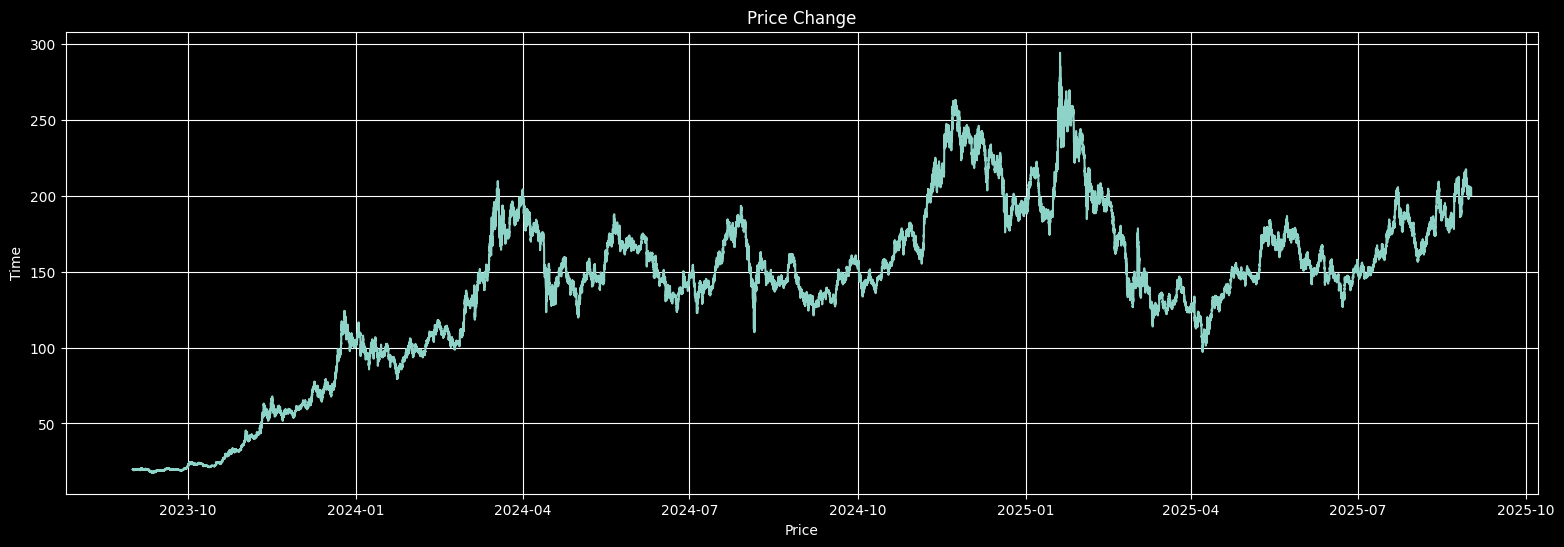

In [19]:
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(19,6))
plt.plot(data.index, data['close'])
plt.xlabel('Price')
plt.ylabel('Time')
plt.title('Price Change')
plt.grid()
plt.show()


## Candle patterns

In [20]:
data = detect_candlestick_patterns(data)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 70176 entries, 2023-09-01 00:00:00+00:00 to 2025-08-31 23:45:00+00:00
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   open                  70176 non-null  float64
 1   high                  70176 non-null  float64
 2   low                   70176 non-null  float64
 3   close                 70176 non-null  float64
 4   volume                70176 non-null  float64
 5   doji                  70176 non-null  bool   
 6   hammer                70176 non-null  bool   
 7   inverted_hammer       70176 non-null  bool   
 8   bullish_engulfing     70176 non-null  bool   
 9   bearish_engulfing     70176 non-null  bool   
 10  piercing_line         70176 non-null  bool   
 11  dark_cloud            70176 non-null  bool   
 12  morning_star          70176 non-null  bool   
 13  evening_star          70176 non-null  bool   
 14  three_white_soldiers  7

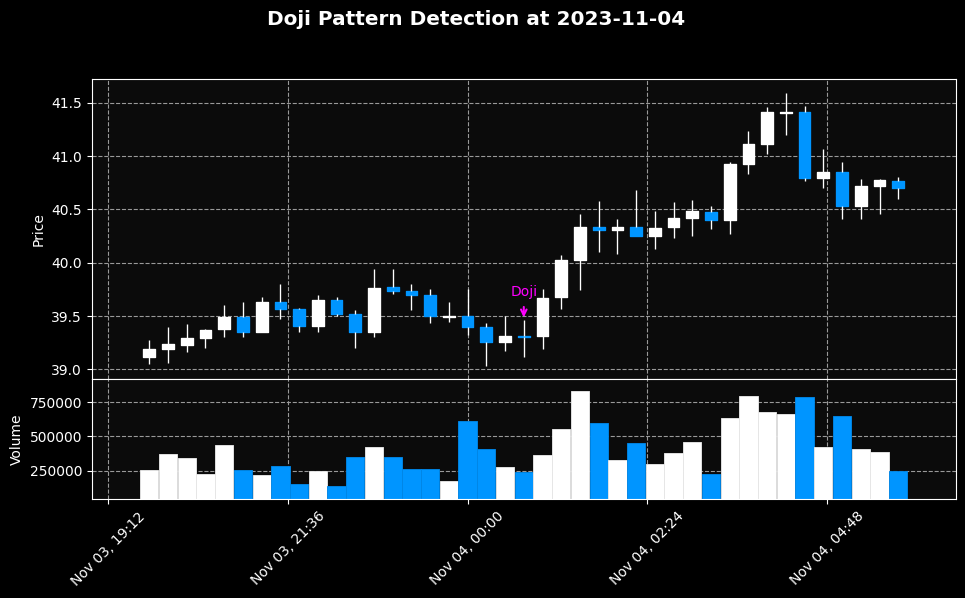

In [21]:
plot_random_pattern(data, 'doji', 'Doji')

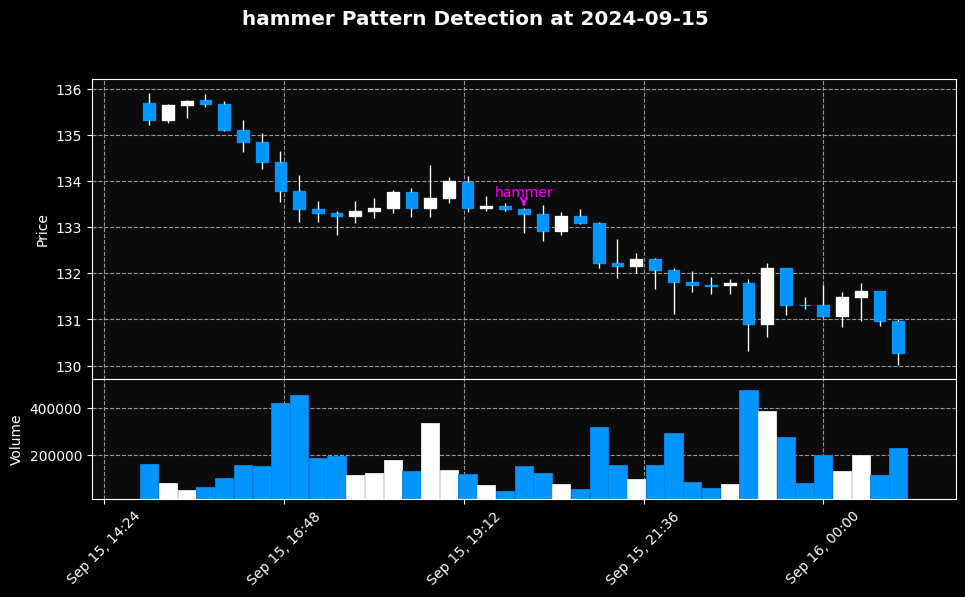

In [22]:
# display a random pattern
plot_random_pattern(data, 'hammer', 'hammer')

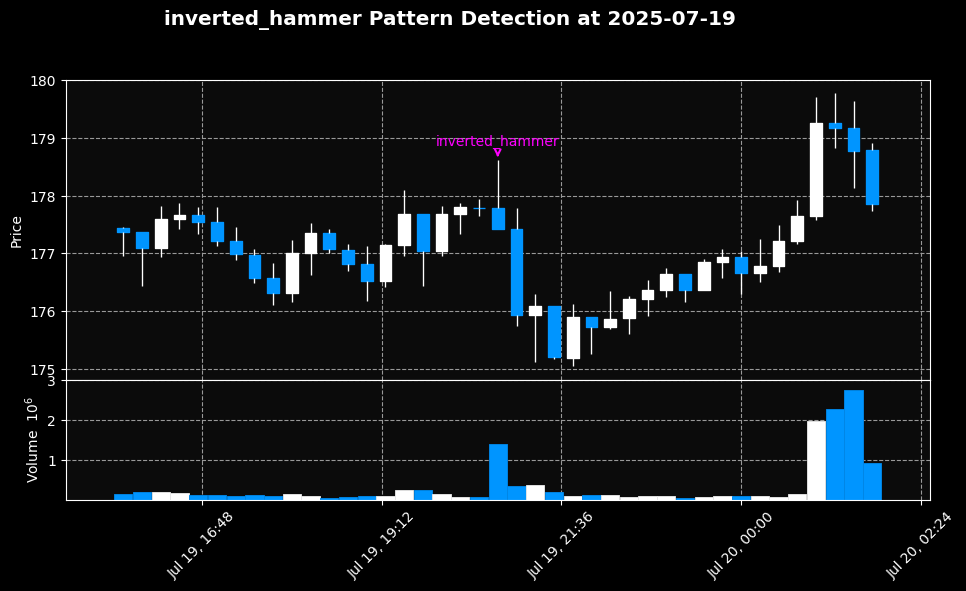

In [23]:
plot_random_pattern(data, 'inverted_hammer', 'inverted_hammer')

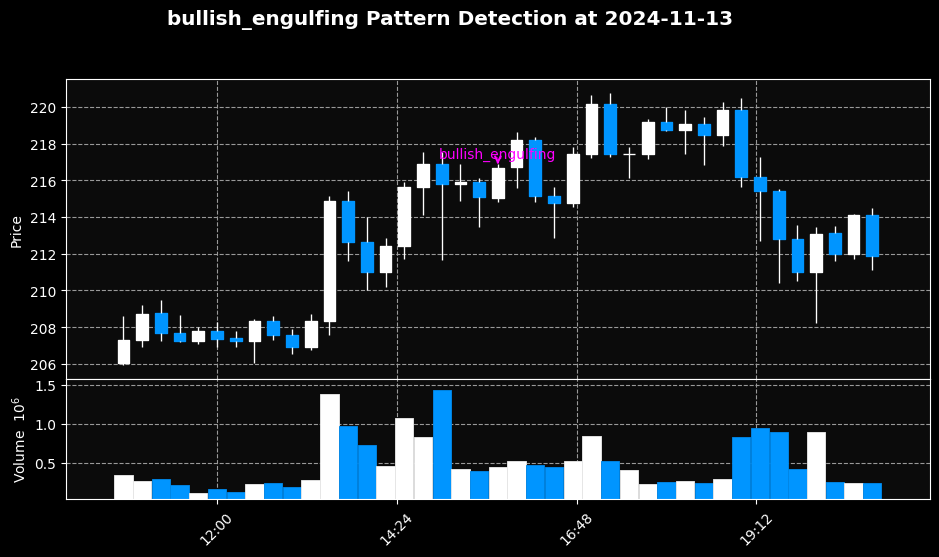

In [24]:
plot_random_pattern(data, 'bullish_engulfing', 'bullish_engulfing')

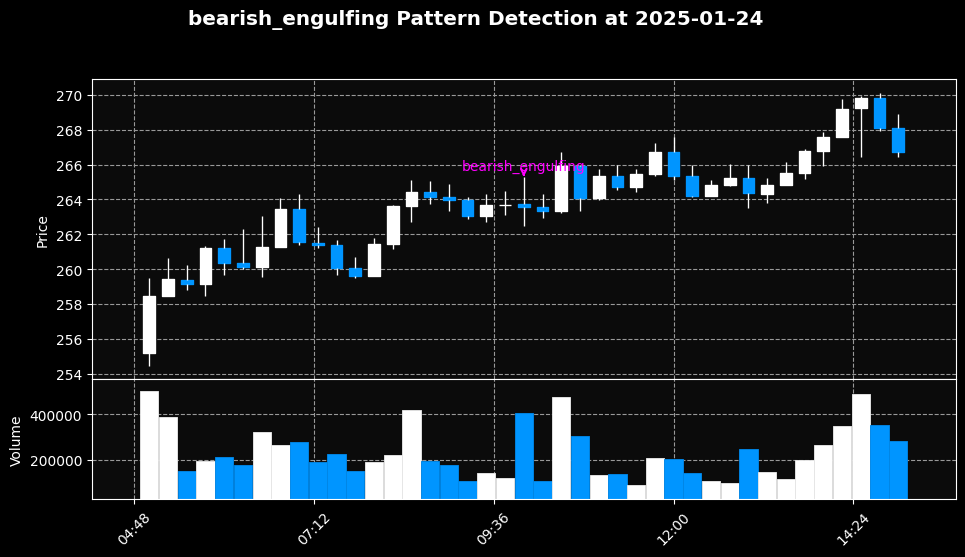

In [25]:
plot_random_pattern(data, 'bearish_engulfing', 'bearish_engulfing')

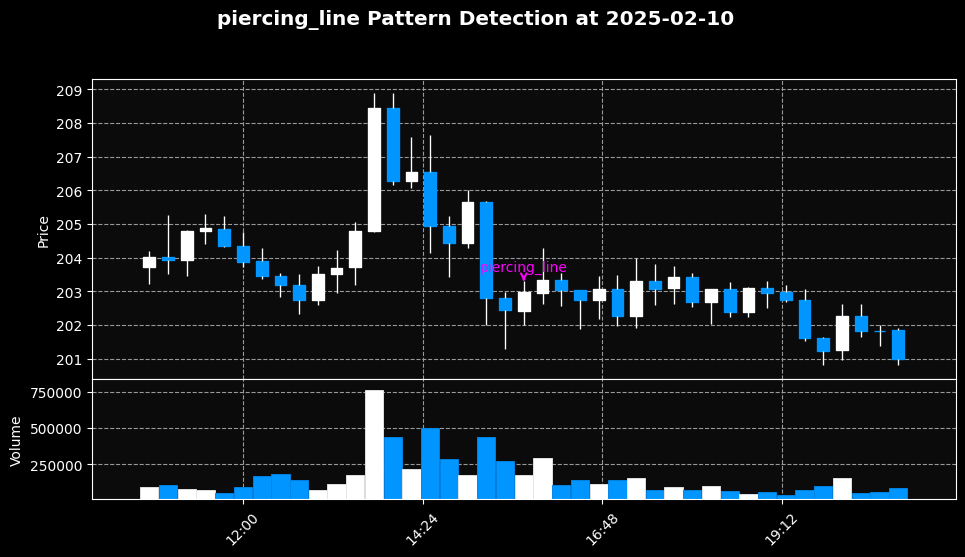

In [26]:
plot_random_pattern(data, 'piercing_line', 'piercing_line')

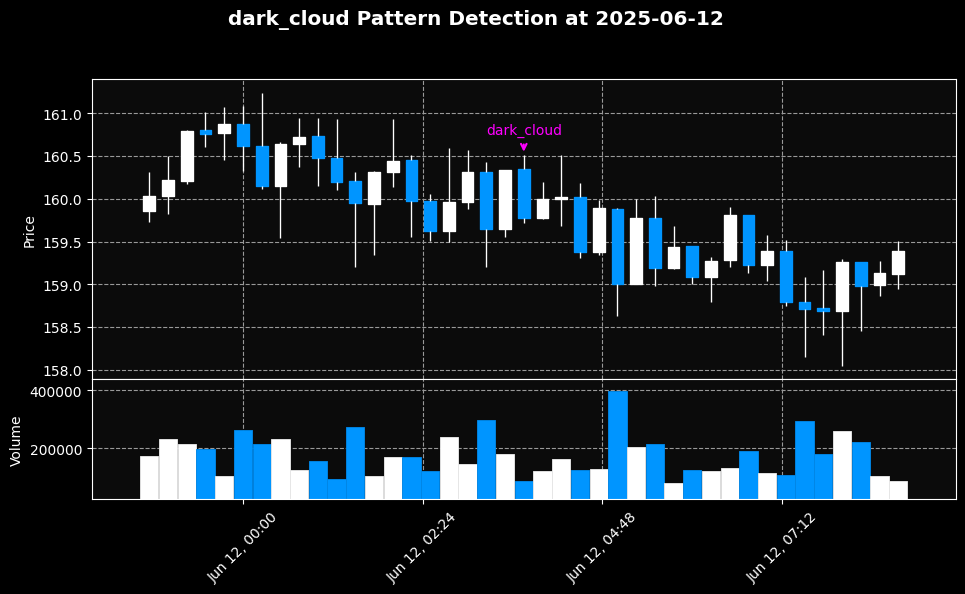

In [27]:
plot_random_pattern(data, 'dark_cloud', 'dark_cloud')

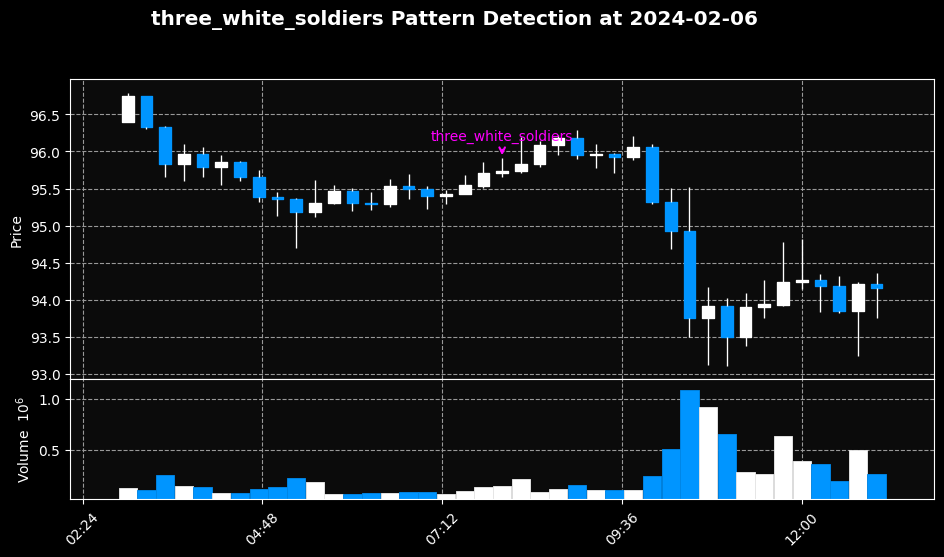

In [28]:
plot_random_pattern(data, 'three_white_soldiers', 'three_white_soldiers')

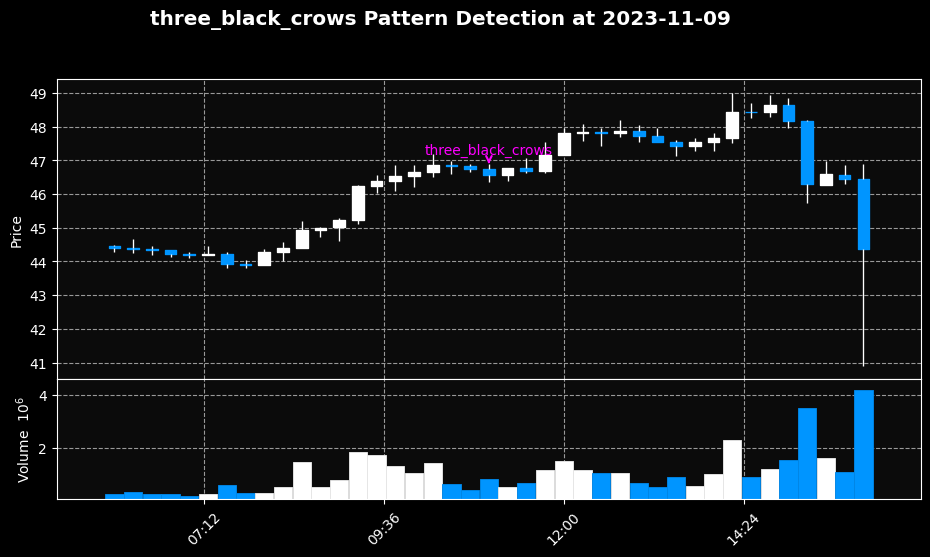

In [29]:
plot_random_pattern(data, 'three_black_crows', 'three_black_crows')

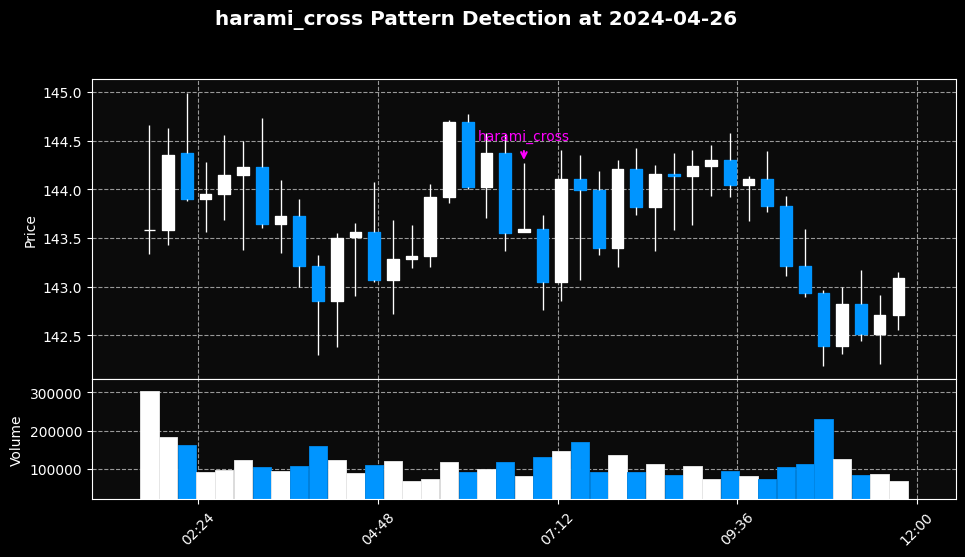

In [30]:
plot_random_pattern(data, 'harami_cross', 'harami_cross')

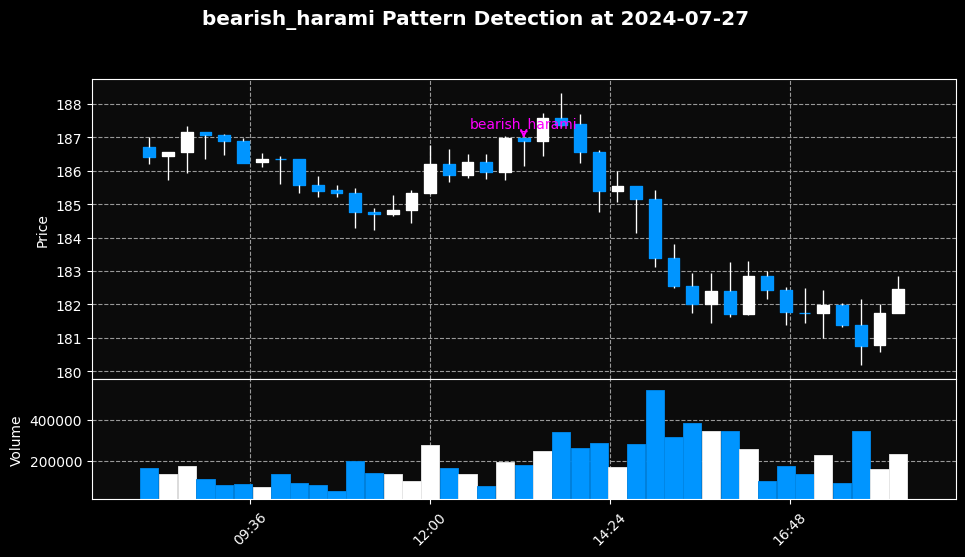

In [31]:
plot_random_pattern(data, 'bearish_harami', 'bearish_harami')

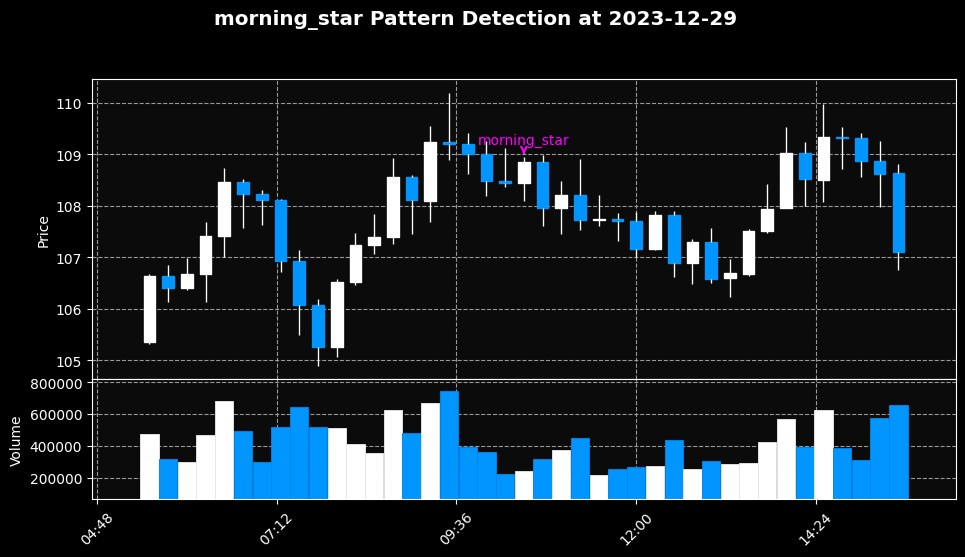

In [32]:
plot_random_pattern(data, 'morning_star', 'morning_star')

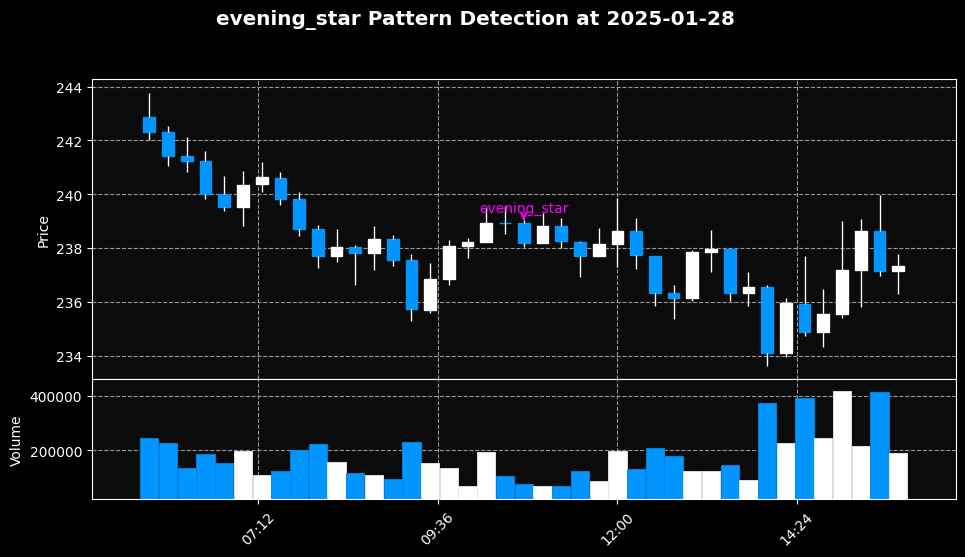

In [33]:
plot_random_pattern(data, 'evening_star', 'evening_star')

Patterns count

In [34]:
# Считаем количество True для всех свечных паттернов
pattern_cols = [
    "doji", "hammer", "inverted_hammer", "three_white_soldiers", "three_black_crows",
    "bullish_engulfing", "bearish_engulfing", "dark_cloud", "harami_cross",
    "morning_star", "evening_star", "piercing_line", "bearish_harami"
]

pattern_counts = {col: int(data[col].sum()) for col in pattern_cols}

# Печатаем статистику
for col, count in pattern_counts.items():
    print(f"{col.replace('_', ' ').title()} patterns: {count}")

print(f"\nTotal patterns: {sum(pattern_counts.values())}")

# Удаляем колонки, где нет ни одного сигнала
for col, count in pattern_counts.items():
    if count == 0:
        data.drop(columns=[col], inplace=True)


Doji patterns: 6686
Hammer patterns: 1256
Inverted Hammer patterns: 1085
Three White Soldiers patterns: 7912
Three Black Crows patterns: 7622
Bullish Engulfing patterns: 2434
Bearish Engulfing patterns: 2270
Dark Cloud patterns: 10
Harami Cross patterns: 2
Morning Star patterns: 3136
Evening Star patterns: 3244
Piercing Line patterns: 3542
Bearish Harami patterns: 44

Total patterns: 39243


## Indicators

In [35]:
! pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=d9be606b9fddadcef9b9f30c29c5c03bd375f0af2b43e01a58866ab74009efa3
  Stored in directory: /root/.cache/pip/wheels/5c/a1/5f/c6b85a7d9452057be4ce68a8e45d77ba34234a6d46581777c6
Successfully built ta


In [36]:
from ta import add_all_ta_features

In [37]:
# data = add_all_ta_features(data, open="open", high="high", low="low", close="close", volume="volume", fillna=True)

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 70176 entries, 2023-09-01 00:00:00+00:00 to 2025-08-31 23:45:00+00:00
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   open                  70176 non-null  float64
 1   high                  70176 non-null  float64
 2   low                   70176 non-null  float64
 3   close                 70176 non-null  float64
 4   volume                70176 non-null  float64
 5   doji                  70176 non-null  bool   
 6   hammer                70176 non-null  bool   
 7   inverted_hammer       70176 non-null  bool   
 8   bullish_engulfing     70176 non-null  bool   
 9   bearish_engulfing     70176 non-null  bool   
 10  piercing_line         70176 non-null  bool   
 11  dark_cloud            70176 non-null  bool   
 12  morning_star          70176 non-null  bool   
 13  evening_star          70176 non-null  bool   
 14  three_white_soldiers  7

In [39]:
# for col in df.columns:
#     print(col)

In [40]:
data.head()

open    high     low   close    volume   doji  \
Date                                                                         
2023-09-01 00:00:00+00:00  19.721  19.791  19.681  19.774  279303.0  False   
2023-09-01 00:15:00+00:00  19.776  19.845  19.758  19.835  220583.0  False   
2023-09-01 00:30:00+00:00  19.835  19.912  19.822  19.880  171197.0  False   
2023-09-01 00:45:00+00:00  19.880  19.898  19.853  19.858  123028.0  False   
2023-09-01 01:00:00+00:00  19.858  19.868  19.804  19.805  131294.0  False   

                           hammer  inverted_hammer  bullish_engulfing  \
Date                                                                    
2023-09-01 00:00:00+00:00   False            False              False   
2023-09-01 00:15:00+00:00   False            False              False   
2023-09-01 00:30:00+00:00   False            False              False   
2023-09-01 00:45:00+00:00   False            False              False   
2023-09-01 01:00:00+00:00   False            False              False   

                           bearish_engulfing  piercing_line  dark_cloud  \
Date                                                                      
2023-09-01 00:00:00+00:00              False          False       False   
2023-09-01 00:15:00+00:00              False          False       False   
2023-09-01 00:30:00+00:00              False          False       False   
2023-09-01 00:45:00+00:00              False          False       False   
2023-09-01 01:00:00+00:00              False          False       False   

                           morning_star  evening_star  three_white_soldiers  \
Date                                                                          
2023-09-01 00:00:00+00:00         False         False                 False   
2023-09-01 00:15:00+00:00         False         False                 False   
2023-09-01 00:30:00+00:00         False         False                  True   
2023-09-01 00:45:00+00:00         False         False                 False   
2023-09-01 01:00:00+00:00         False          True                 False   

                           three_black_crows  harami_cross  bearish_harami  
Date                                                                        
2023-09-01 00:00:00+00:00              False         False           False  
2023-09-01 00:15:00+00:00              False         False           False  
2023-09-01 00:30:00+00:00              False         False           False  
2023-09-01 00:45:00+00:00              False         False           False  
2023-09-01 01:00:00+00:00              False         False           False

In [41]:
# indecators culculations
data['ATR'] = talib.ATR(data['high'], data['low'], data['close'], timeperiod=14)
data['historical_volatility'] = talib.NATR(data['high'], data['low'], data['close'], timeperiod=14)
data['SMA_10'] = talib.SMA(data['close'], timeperiod=10)
data['SMA_30'] = talib.SMA(data['close'], timeperiod=30)
data['SMA_50'] = talib.SMA(data['close'], timeperiod=50)
data['SMA_100'] = talib.SMA(data['close'], timeperiod=100)
data['SMA_200'] = talib.SMA(data['close'], timeperiod=100)
data['EMA_10'] = talib.EMA(data['close'], timeperiod=10)
data['EMA_30'] = talib.EMA(data['close'], timeperiod=30)
data['EMA_50'] = talib.EMA(data['close'], timeperiod=50)
data['EMA_100'] = talib.EMA(data['close'], timeperiod=100)
data['EMA_200'] = talib.SMA(data['close'], timeperiod=100)
data['RSI_14'] = talib.RSI(data['close'], timeperiod=14)
data['MACD'], data['MACD_signal'], _ = talib.MACD(data['close'], fastperiod=12, slowperiod=26, signalperiod=9)
data['bollinger_high'], data['bollinger_mid'], data['bollinger_low'] = talib.BBANDS(data['close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
data['volume_mean_10'] = data['volume'].rolling(window=10).mean()
data['volume_mean_30'] = data['volume'].rolling(window=30).mean()
data['parabolic_SAR'] = talib.SAR(data['high'], data['low'], acceleration=0.02, maximum=0.2)
data['ADX'] = talib.ADX(data['high'], data['low'], data['close'], timeperiod=14)
data['CCI'] = talib.CCI(data['high'], data['low'], data['close'], timeperiod=14)
data['stochastic_oscillator_k'], data['stochastic_oscillator_d'] = talib.STOCH(data['high'], data['low'], data['close'],
                                                                               fastk_period=14, slowk_period=3, slowk_matype=0,
                                                                               slowd_period=3, slowd_matype=0)



# Removing rows with NaN values
data.dropna(inplace=True)
data

open     high      low    close     volume  \
Date                                                                       
2023-09-02 00:45:00+00:00   19.383   19.392   19.333   19.386  102818.00   
2023-09-02 01:00:00+00:00   19.386   19.423   19.352   19.413  114444.00   
2023-09-02 01:15:00+00:00   19.412   19.461   19.402   19.446  152822.00   
2023-09-02 01:30:00+00:00   19.446   19.472   19.402   19.419  150304.00   
2023-09-02 01:45:00+00:00   19.419   19.449   19.394   19.419  157916.00   
...                            ...      ...      ...      ...        ...   
2025-08-31 22:45:00+00:00  203.760  204.110  203.300  203.640  253050.63   
2025-08-31 23:00:00+00:00  203.650  203.820  203.040  203.400  258766.38   
2025-08-31 23:15:00+00:00  203.410  203.410  202.240  202.350  363684.74   
2025-08-31 23:30:00+00:00  202.360  202.380  200.510  200.600  773470.32   
2025-08-31 23:45:00+00:00  200.600  201.110  200.200  200.570  383655.13   

                            doji  hammer  inverted_hammer  bullish_engulfing  \
Date                                                                           
2023-09-02 00:45:00+00:00   True   False            False              False   
2023-09-02 01:00:00+00:00  False   False            False              False   
2023-09-02 01:15:00+00:00  False   False            False              False   
2023-09-02 01:30:00+00:00  False   False            False              False   
2023-09-02 01:45:00+00:00   True   False            False              False   
...                          ...     ...              ...                ...   
2025-08-31 22:45:00+00:00  False   False            False              False   
2025-08-31 23:00:00+00:00  False   False            False              False   
2025-08-31 23:15:00+00:00  False   False            False              False   
2025-08-31 23:30:00+00:00  False   False            False              False   
2025-08-31 23:45:00+00:00   True   False            False              False   

                           bearish_engulfing  ...  bollinger_high  \
Date                                          ...                   
2023-09-02 00:45:00+00:00              False  ...       19.425642   
2023-09-02 01:00:00+00:00              False  ...       19.440735   
2023-09-02 01:15:00+00:00              False  ...       19.454623   
2023-09-02 01:30:00+00:00              False  ...       19.460202   
2023-09-02 01:45:00+00:00              False  ...       19.472417   
...                                      ...  ...             ...   
2025-08-31 22:45:00+00:00              False  ...      205.719924   
2025-08-31 23:00:00+00:00              False  ...      205.809799   
2025-08-31 23:15:00+00:00              False  ...      206.077941   
2025-08-31 23:30:00+00:00              False  ...      206.621298   
2025-08-31 23:45:00+00:00              False  ...      206.838228   

                           bollinger_mid  bollinger_low  volume_mean_10  \
Date                                                                      
2023-09-02 00:45:00+00:00       19.30270      19.179758      108886.900   
2023-09-02 01:00:00+00:00       19.30920      19.177665      108720.000   
2023-09-02 01:15:00+00:00       19.31275      19.170877      115148.500   
2023-09-02 01:30:00+00:00       19.31435      19.168498      121796.900   
2023-09-02 01:45:00+00:00       19.31960      19.166783      127660.400   
...                                  ...            ...             ...   
2025-08-31 22:45:00+00:00      204.80200     203.884076      110377.079   
2025-08-31 23:00:00+00:00      204.71800     203.626201      131268.858   
2025-08-31 23:15:00+00:00      204.58550     203.093059      163366.805   
2025-08-31 23:30:00+00:00      204.35700     202.092702      233215.312   
2025-08-31 23:45:00+00:00      204.10750     201.376772      265878.738   

                           volume_mean_30  parabolic_SAR        ADX  \
Date                                                   

In [42]:
data.head(3)

open    high     low   close    volume   doji  \
Date                                                                         
2023-09-02 00:45:00+00:00  19.383  19.392  19.333  19.386  102818.0   True   
2023-09-02 01:00:00+00:00  19.386  19.423  19.352  19.413  114444.0  False   
2023-09-02 01:15:00+00:00  19.412  19.461  19.402  19.446  152822.0  False   

                           hammer  inverted_hammer  bullish_engulfing  \
Date                                                                    
2023-09-02 00:45:00+00:00   False            False              False   
2023-09-02 01:00:00+00:00   False            False              False   
2023-09-02 01:15:00+00:00   False            False              False   

                           bearish_engulfing  ...  bollinger_high  \
Date                                          ...                   
2023-09-02 00:45:00+00:00              False  ...       19.425642   
2023-09-02 01:00:00+00:00              False  ...       19.440735   
2023-09-02 01:15:00+00:00              False  ...       19.454623   

                           bollinger_mid  bollinger_low  volume_mean_10  \
Date                                                                      
2023-09-02 00:45:00+00:00       19.30270      19.179758        108886.9   
2023-09-02 01:00:00+00:00       19.30920      19.177665        108720.0   
2023-09-02 01:15:00+00:00       19.31275      19.170877        115148.5   

                           volume_mean_30  parabolic_SAR        ADX  \
Date                                                                  
2023-09-02 00:45:00+00:00   237153.533333      19.265141  15.622092   
2023-09-02 01:00:00+00:00   222207.466667      19.275096  15.718743   
2023-09-02 01:15:00+00:00   211368.033333      19.284652  16.281250   

                                  CCI  stochastic_oscillator_k  \
Date                                                             
2023-09-02 00:45:00+00:00   92.246689                83.171457   
2023-09-02 01:00:00+00:00  103.737416                81.997187   
2023-09-02 01:15:00+00:00  123.244461                87.535768   

                           stochastic_oscillator_d  
Date                                                
2023-09-02 00:45:00+00:00                81.712960  
2023-09-02 01:00:00+00:00                84.329281  
2023-09-02 01:15:00+00:00                84.234804  

[3 rows x 43 columns]

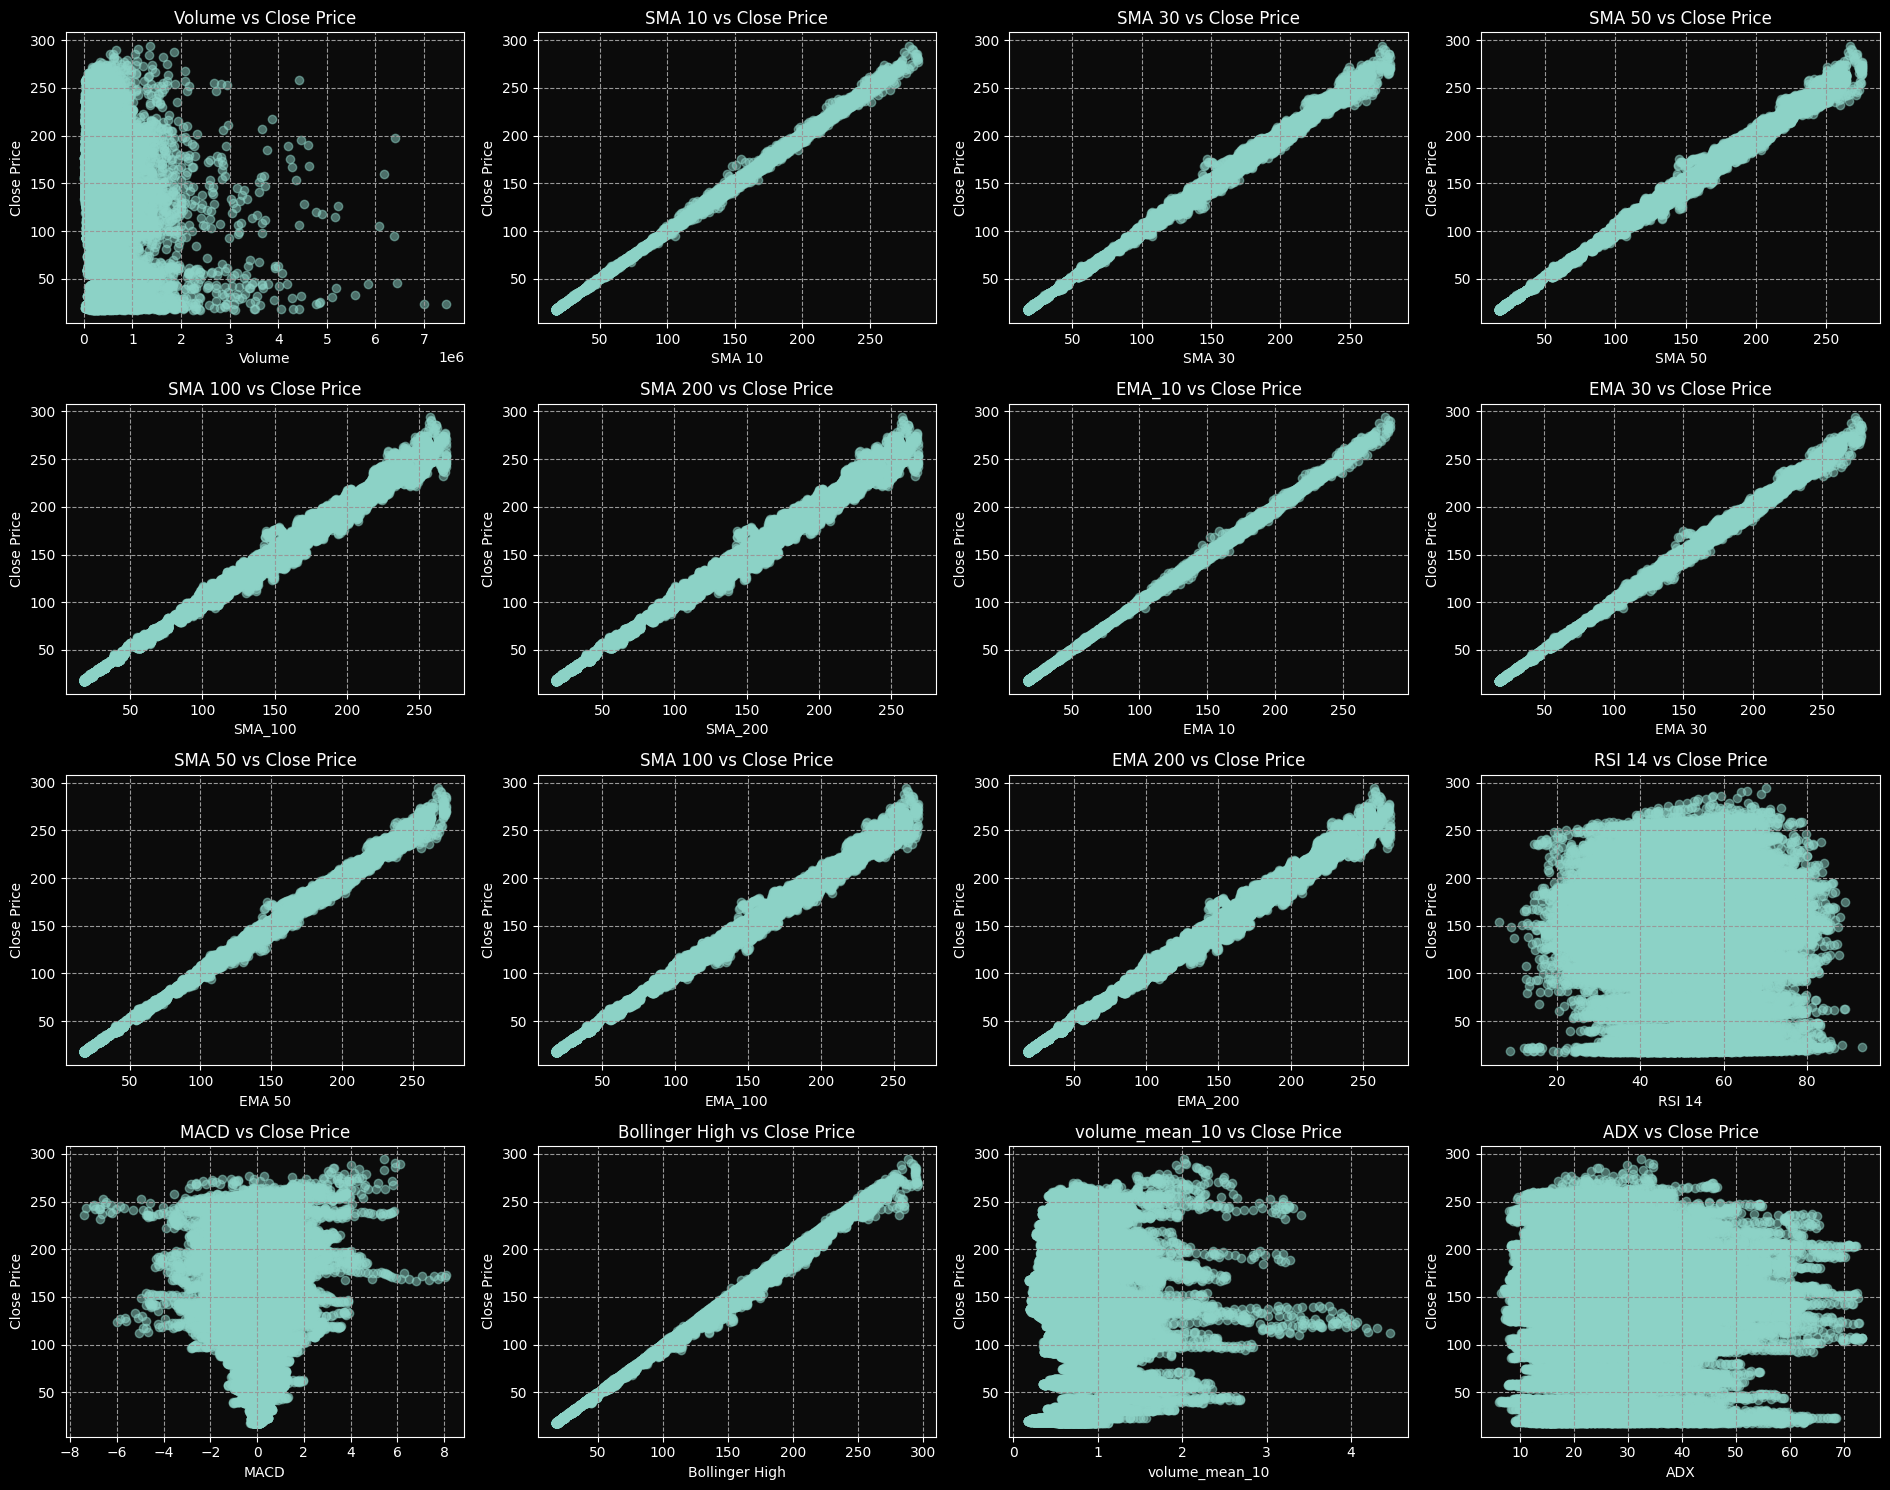

In [43]:
# Visualizing indicators
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(19, 15))


# Scatter plot: Close price vs volume
axes[0, 0].scatter(data['volume'], data['close'], alpha=0.5)
axes[0, 0].set_xlabel('Volume')
axes[0, 0].set_ylabel('Close Price')
axes[0, 0].set_title('Volume vs Close Price')
axes[0, 0].grid(True)

axes[0, 1].scatter(data['SMA_10'], data['close'], alpha=0.5)
axes[0, 1].set_xlabel('SMA 10')
axes[0, 1].set_ylabel('Close Price')
axes[0, 1].set_title('SMA 10 vs Close Price')
axes[0, 1].grid(True)

axes[0, 2].scatter(data['SMA_30'], data['close'], alpha=0.5)
axes[0, 2].set_xlabel('SMA 30')
axes[0, 2].set_ylabel('Close Price')
axes[0, 2].set_title('SMA 30 vs Close Price')
axes[0, 2].grid(True)

axes[0, 3].scatter(data['SMA_50'], data['close'], alpha=0.5)
axes[0, 3].set_xlabel('SMA 50')
axes[0, 3].set_ylabel('Close Price')
axes[0, 3].set_title('SMA 50 vs Close Price')
axes[0, 3].grid(True)

axes[1, 0].scatter(data['SMA_100'], data['close'], alpha=0.5)
axes[1, 0].set_xlabel('SMA_100')
axes[1, 0].set_ylabel('Close Price')
axes[1, 0].set_title('SMA 100 vs Close Price')
axes[1, 0].grid(True)

axes[1, 1].scatter(data['SMA_200'], data['close'], alpha=0.5)
axes[1, 1].set_xlabel('SMA_200')
axes[1, 1].set_ylabel('Close Price')
axes[1, 1].set_title('SMA 200 vs Close Price')
axes[1, 1].grid(True)


axes[1, 2].scatter(data['EMA_10'], data['close'], alpha=0.5)
axes[1, 2].set_xlabel('EMA 10')
axes[1, 2].set_ylabel('Close Price')
axes[1, 2].set_title('EMA_10 vs Close Price')
axes[1, 2].grid(True)

axes[1, 3].scatter(data['EMA_30'], data['close'], alpha=0.5)
axes[1, 3].set_xlabel('EMA 30')
axes[1, 3].set_ylabel('Close Price')
axes[1, 3].set_title('EMA 30 vs Close Price')
axes[1, 3].grid(True)

axes[2, 0].scatter(data['EMA_50'], data['close'], alpha=0.5)
axes[2, 0].set_xlabel('EMA 50')
axes[2, 0].set_ylabel('Close Price')
axes[2, 0].set_title('SMA 50 vs Close Price')
axes[2, 0].grid(True)

axes[2, 1].scatter(data['EMA_100'], data['close'], alpha=0.5)
axes[2, 1].set_xlabel('EMA_100')
axes[2, 1].set_ylabel('Close Price')
axes[2, 1].set_title('SMA 100 vs Close Price')
axes[2, 1].grid(True)

axes[2, 2].scatter(data['EMA_200'], data['close'], alpha=0.5)
axes[2, 2].set_xlabel('EMA_200')
axes[2, 2].set_ylabel('Close Price')
axes[2, 2].set_title('EMA 200 vs Close Price')
axes[2, 2].grid(True)


axes[2,  3].scatter(data['RSI_14'], data['close'], alpha=0.5)
axes[2,  3].set_xlabel('RSI 14')
axes[2,  3].set_ylabel('Close Price')
axes[2,  3].set_title('RSI 14 vs Close Price')
axes[2,  3].grid(True)


axes[3, 0].scatter(data['MACD'], data['close'], alpha=0.5)
axes[3, 0].set_xlabel('MACD')
axes[3, 0].set_ylabel('Close Price')
axes[3, 0].set_title('MACD vs Close Price')
axes[3, 0].grid(True)


axes[3, 1].scatter(data['bollinger_high'], data['close'], alpha=0.5)
axes[3, 1].set_xlabel('Bollinger High')
axes[3, 1].set_ylabel('Close Price')
axes[3, 1].set_title('Bollinger High vs Close Price')
axes[3, 1].grid(True)


axes[3, 2].scatter(data['historical_volatility'], data['close'], alpha=0.5)
axes[3, 2].set_xlabel('volume_mean_10')
axes[3, 2].set_ylabel('Close Price')
axes[3, 2].set_title('volume_mean_10 vs Close Price')
axes[3, 2].grid(True)


axes[3, 3].scatter(data['ADX'], data['close'], alpha=0.5)
axes[3, 3].set_xlabel('ADX')
axes[3, 3].set_ylabel('Close Price')
axes[3, 3].set_title('ADX vs Close Price')
axes[3, 3].grid(True)

plt.tight_layout()
plt.show()

## Percentage price change algorithm. Target

In [44]:
# data['return'] is the future return of the next candle relative to the current closing price.
data['return'] = data['close'].pct_change().shift(-1)

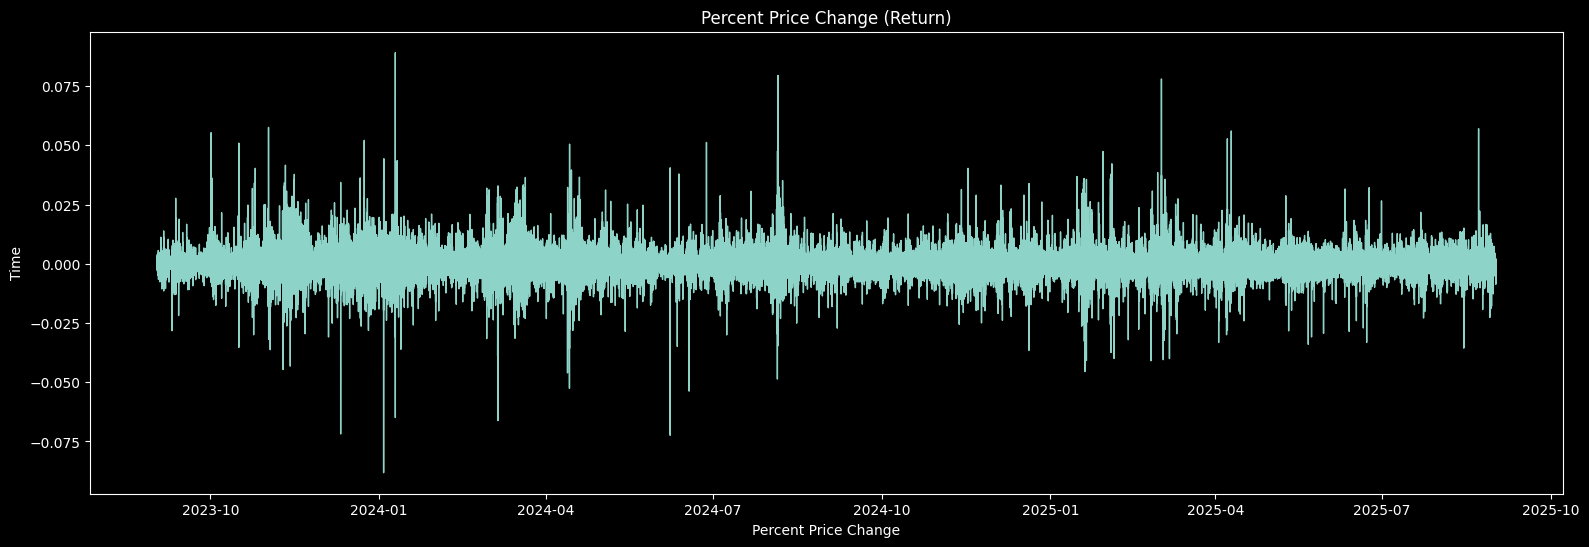

In [45]:
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(19,6))
plt.plot(data.index, data['return'])
plt.xlabel('Percent Price Change')
plt.ylabel('Time')
plt.title('Percent Price Change (Return)')
plt.grid()
plt.show()


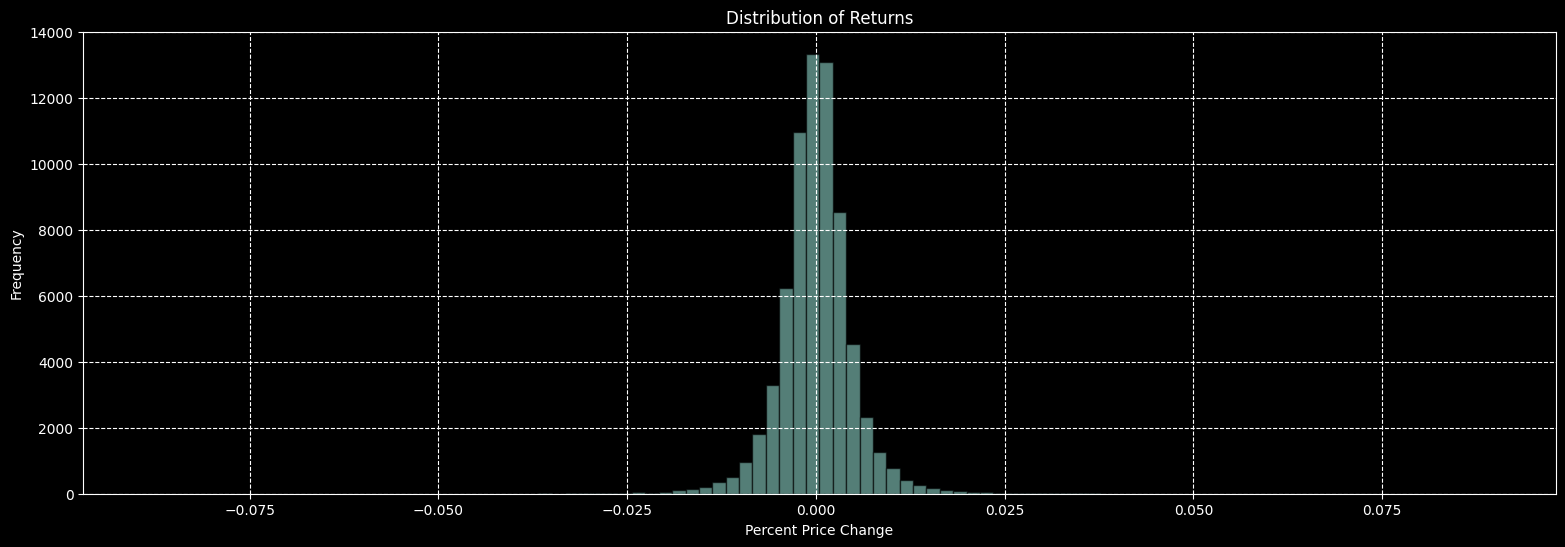

In [46]:
# simple yield calculation
fig, ax = plt.subplots(figsize=(19, 6))
plt.hist(data['return'], bins=100, edgecolor='black', alpha=0.6)
plt.xlabel('Percent Price Change')
plt.ylabel('Frequency')
plt.title('Distribution of Returns')
plt.show()

Based on the graph, we can judge that the profitability has a normal distribution.

If the price per hour increases by half a percent, then put the mark 1, otherwise mark 0

In [47]:
import numpy as np


percentage_change = 0.005  # 0.5%

data['price_change'] = data['close'].pct_change() # % price change
future_change = data['price_change'].shift(-1) # % price change of the next candle

conditions = [future_change > percentage_change,
              future_change < -percentage_change
              ]

labels = [1, -1] # 1 - long, -1 - short
data['trade_signal'] = np.select(conditions, labels, default=0)

In [48]:
data.head()

open    high     low   close    volume   doji  \
Date                                                                         
2023-09-02 00:45:00+00:00  19.383  19.392  19.333  19.386  102818.0   True   
2023-09-02 01:00:00+00:00  19.386  19.423  19.352  19.413  114444.0  False   
2023-09-02 01:15:00+00:00  19.412  19.461  19.402  19.446  152822.0  False   
2023-09-02 01:30:00+00:00  19.446  19.472  19.402  19.419  150304.0  False   
2023-09-02 01:45:00+00:00  19.419  19.449  19.394  19.419  157916.0   True   

                           hammer  inverted_hammer  bullish_engulfing  \
Date                                                                    
2023-09-02 00:45:00+00:00   False            False              False   
2023-09-02 01:00:00+00:00   False            False              False   
2023-09-02 01:15:00+00:00   False            False              False   
2023-09-02 01:30:00+00:00   False            False              False   
2023-09-02 01:45:00+00:00   False            False              False   

                           bearish_engulfing  ...  volume_mean_10  \
Date                                          ...                   
2023-09-02 00:45:00+00:00              False  ...        108886.9   
2023-09-02 01:00:00+00:00              False  ...        108720.0   
2023-09-02 01:15:00+00:00              False  ...        115148.5   
2023-09-02 01:30:00+00:00              False  ...        121796.9   
2023-09-02 01:45:00+00:00              False  ...        127660.4   

                           volume_mean_30  parabolic_SAR        ADX  \
Date                                                                  
2023-09-02 00:45:00+00:00   237153.533333      19.265141  15.622092   
2023-09-02 01:00:00+00:00   222207.466667      19.275096  15.718743   
2023-09-02 01:15:00+00:00   211368.033333      19.284652  16.281250   
2023-09-02 01:30:00+00:00   204843.400000      19.293826  16.935919   
2023-09-02 01:45:00+00:00   201852.133333      19.302633  17.376818   

                                  CCI  stochastic_oscillator_k  \
Date                                                             
2023-09-02 00:45:00+00:00   92.246689                83.171457   
2023-09-02 01:00:00+00:00  103.737416                81.997187   
2023-09-02 01:15:00+00:00  123.244461                87.535768   
2023-09-02 01:30:00+00:00  100.981836                88.213666   
2023-09-02 01:45:00+00:00   79.721800                85.094095   

                           stochastic_oscillator_d    return  price_change  \
Date                                                                         
2023-09-02 00:45:00+00:00                81.712960  0.001393           NaN   
2023-09-02 01:00:00+00:00                84.329281  0.001700      0.001393   
2023-09-02 01:15:00+00:00                84.234804 -0.001388      0.001700   
2023-09-02 01:30:00+00:00                85.915540  0.000000     -0.001388   
2023-09-02 01:45:00+00:00                86.947843  0.003347      0.000000   

                           trade_signal  
Date                                     
2023-09-02 00:45:00+00:00             0  
2023-09-02 01:00:00+00:00             0  
2023-09-02 01:15:00+00:00             0  
2023-09-02 01:30:00+00:00             0  
2023-09-02 01:45:00+00:00             0  

[5 rows x 46 columns]

## Data Preprocessing - Stationarity

In [49]:
df_stationary = make_stationary(data)
df_stationary.head()

Нестационарные признаки: 18


open      high       low     close    volume  \
Date                                                                          
2023-09-02 01:00:00+00:00  2.964551  2.966458  2.962796  2.965943  114444.0   
2023-09-02 01:15:00+00:00  2.965891  2.968412  2.965376  2.967641  152822.0   
2023-09-02 01:30:00+00:00  2.967641  2.968978  2.965376  2.966252  150304.0   
2023-09-02 01:45:00+00:00  2.966252  2.967796  2.964964  2.966252  157916.0   
2023-09-02 02:00:00+00:00  2.966252  2.969902  2.966149  2.969594  165002.0   

                            doji  hammer  inverted_hammer  bullish_engulfing  \
Date                                                                           
2023-09-02 01:00:00+00:00  False   False            False              False   
2023-09-02 01:15:00+00:00  False   False            False              False   
2023-09-02 01:30:00+00:00  False   False            False              False   
2023-09-02 01:45:00+00:00   True   False            False              False   
2023-09-02 02:00:00+00:00  False   False            False              False   

                           bearish_engulfing  ...  volume_mean_10  \
Date                                          ...                   
2023-09-02 01:00:00+00:00              False  ...        108720.0   
2023-09-02 01:15:00+00:00              False  ...        115148.5   
2023-09-02 01:30:00+00:00              False  ...        121796.9   
2023-09-02 01:45:00+00:00              False  ...        127660.4   
2023-09-02 02:00:00+00:00              False  ...        135422.3   

                           volume_mean_30  parabolic_SAR        ADX  \
Date                                                                  
2023-09-02 01:00:00+00:00   222207.466667       2.958814  15.718743   
2023-09-02 01:15:00+00:00   211368.033333       2.959310  16.281250   
2023-09-02 01:30:00+00:00   204843.400000       2.959785  16.935919   
2023-09-02 01:45:00+00:00   201852.133333       2.960242  17.376818   
2023-09-02 02:00:00+00:00   191953.300000       2.960679  18.298507   

                                  CCI  stochastic_oscillator_k  \
Date                                                             
2023-09-02 01:00:00+00:00  103.737416                81.997187   
2023-09-02 01:15:00+00:00  123.244461                87.535768   
2023-09-02 01:30:00+00:00  100.981836                88.213666   
2023-09-02 01:45:00+00:00   79.721800                85.094095   
2023-09-02 02:00:00+00:00  114.448771                86.269063   

                           stochastic_oscillator_d    return  price_change  \
Date                                                                         
2023-09-02 01:00:00+00:00                84.329281  0.001700      0.001393   
2023-09-02 01:15:00+00:00                84.234804 -0.001388      0.001700   
2023-09-02 01:30:00+00:00                85.915540  0.000000     -0.001388   
2023-09-02 01:45:00+00:00                86.947843  0.003347      0.000000   
2023-09-02 02:00:00+00:00                86.525608  0.000770      0.003347   

                           trade_signal  
Date                                     
2023-09-02 01:00:00+00:00             0  
2023-09-02 01:15:00+00:00             0  
2023-09-02 01:30:00+00:00             0  
2023-09-02 01:45:00+00:00             0  
2023-09-02 02:00:00+00:00             0  

[5 rows x 46 columns]

In [50]:
df_stationary.isna().sum()

open                       0
high                       0
low                        0
close                      0
volume                     0
doji                       0
hammer                     0
inverted_hammer            0
bullish_engulfing          0
bearish_engulfing          0
piercing_line              0
dark_cloud                 0
morning_star               0
evening_star               0
three_white_soldiers       0
three_black_crows          0
harami_cross               0
bearish_harami             0
ATR                        0
historical_volatility      0
SMA_10                     0
SMA_30                     0
SMA_50                     0
SMA_100                    0
SMA_200                    0
EMA_10                     0
EMA_30                     0
EMA_50                     0
EMA_100                    0
EMA_200                    0
RSI_14                     0
MACD                       0
MACD_signal                0
bollinger_high             0
bollinger_mid              0
bollinger_low              0
volume_mean_10             0
volume_mean_30             0
parabolic_SAR              0
ADX                        0
CCI                        0
stochastic_oscillator_k    0
stochastic_oscillator_d    0
return                     0
price_change               0
trade_signal               0
dtype: int64

## Data Preprocessing - Colleration

Outliers in column 'open':
Outlier Count: 8713
Outlier Percentage of total observations: 12.43%
Outlier Values: 2.9645511560704163, 2.96589143154297, 2.9676413933874652, 2.9662519682314827, 2.9662519682314827, 2.96954229046375, 2.9703631822034495, 2.967538539183209, 2.9666638510566434, 2.9707221105498234, 2.969952820566504, 2.9723101036094985, 2.973282144716399, 2.9764475121421237, 2.976651385741199, 2.974048878722832, 2.9728729794079083, 2.974917133840071, 2.9731798690834794, 2.972054146199414, 2.971849333090659, 2.9733844098900835, 2.969952820566504, 2.969182938320454, 2.9681555057837565, 2.9692856235390077, 2.9705682998904415, 2.9733844098900835, 2.9734355385553806, 2.9758866453332846, 2.972463646614637, 2.9717469108034797, 2.9707221105498234, 2.972463646614637, 2.9745086371023644, 2.9742021550036277, 2.974968184201263, 2.974457563275136, 2.974151065520387, 2.9764984844386917, 2.9733844098900835, 2.973026436018353, 2.972975286431375, 2.9725659955221517, 2.9734355385553806, 2.9737933

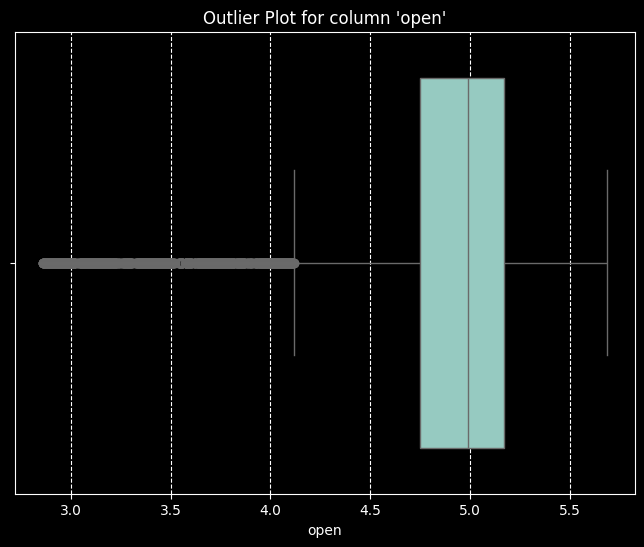

***************************************************************************

Outliers in column 'high':
Outlier Count: 8720
Outlier Percentage of total observations: 12.44%
Outlier Values: 2.966457930849996, 2.968412462899028, 2.9689775362451716, 2.9677956548609683, 2.9699015135194693, 2.970619572738916, 2.9703631822034495, 2.968617981062419, 2.9712858806490647, 2.970824637847806, 2.9742021550036277, 2.9747129063299154, 2.9779246549040264, 2.97756830292632, 2.977109949425896, 2.9745086371023644, 2.9762435969701286, 2.9751213196498667, 2.9753254637763282, 2.9735889088683014, 2.9745086371023644, 2.973793366035237, 2.9709784090877616, 2.9703631822034495, 2.97000412498126, 2.9708758975551244, 2.9751213196498667, 2.9745086371023644, 2.977822853010423, 2.9759376462258116, 2.973640027079175, 2.9736911426771107, 2.9735889088683014, 2.9751213196498667, 2.9751213196498667, 2.9758866453332846, 2.976039640208255, 2.9754275202136267, 2.9770080645557115, 2.978382635218878, 2.9744064868392384, 2.9740

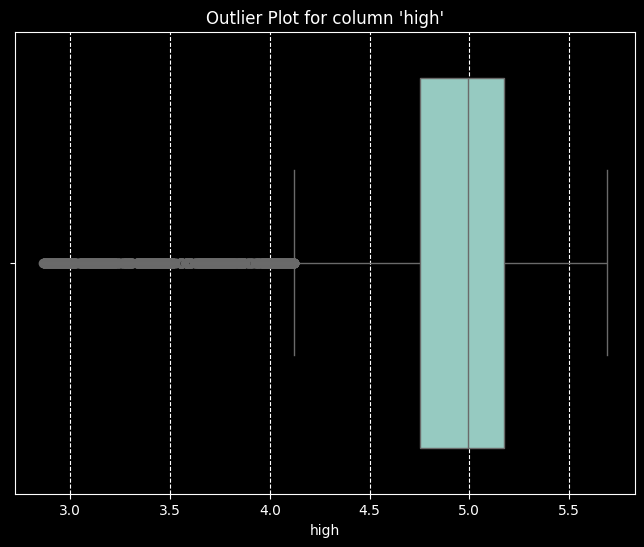

***************************************************************************

Outliers in column 'low':
Outlier Count: 8697
Outlier Percentage of total observations: 12.41%
Outlier Values: 2.962795773307726, 2.9653761535390917, 2.9653761535390917, 2.9649637398823545, 2.966148971012317, 2.967487108113689, 2.9660459631836305, 2.9650153008919307, 2.9666638510566434, 2.968669354004302, 2.9689261791334842, 2.972156537025285, 2.973282144716399, 2.974661842934699, 2.973077582989185, 2.971593257700665, 2.9728729794079083, 2.972156537025285, 2.97179812325836, 2.97092715463502, 2.971849333090659, 2.9689261791334842, 2.968772091971208, 2.967332799032293, 2.9669211916998712, 2.968720724307141, 2.9705170244129273, 2.97261716604794, 2.9733332786105118, 2.971593257700665, 2.970619572738916, 2.9696962590031495, 2.969388298214389, 2.97179812325836, 2.97261716604794, 2.9738444737959617, 2.9739466814820688, 2.973640027079175, 2.974151065520387, 2.972975286431375, 2.9716956957257494, 2.9716956957257494, 2.

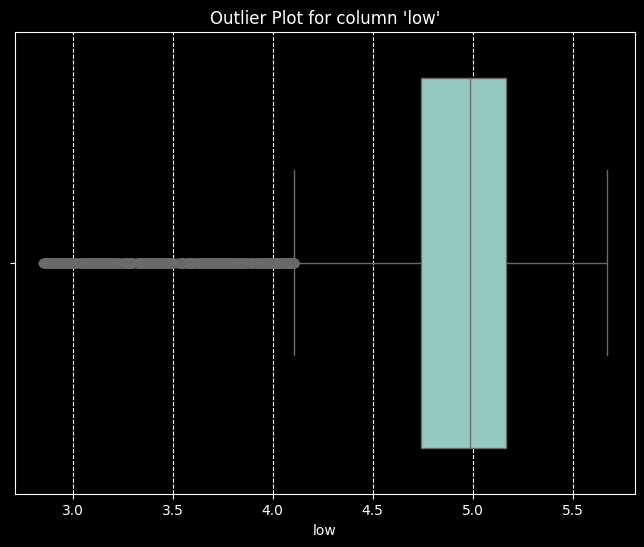

***************************************************************************

Outliers in column 'close':
Outlier Count: 8714
Outlier Percentage of total observations: 12.44%
Outlier Values: 2.965942944743239, 2.9676413933874652, 2.9662519682314827, 2.9662519682314827, 2.969593615944296, 2.9703631822034495, 2.967538539183209, 2.9667153244834985, 2.9707221105498234, 2.969952820566504, 2.9723101036094985, 2.973282144716399, 2.9764475121421237, 2.976651385741199, 2.974048878722832, 2.9729241342279824, 2.974917133840071, 2.973128727344138, 2.9721053429228346, 2.97179812325836, 2.9733332786105118, 2.9699015135194693, 2.969182938320454, 2.968104106436517, 2.9692856235390077, 2.9705170244129273, 2.9733332786105118, 2.9733844098900835, 2.9758866453332846, 2.972463646614637, 2.9716956957257494, 2.9707221105498234, 2.9725148223778066, 2.9745086371023644, 2.974151065520387, 2.974917133840071, 2.974457563275136, 2.974151065520387, 2.9764984844386917, 2.9733844098900835, 2.973026436018353, 2.9729241

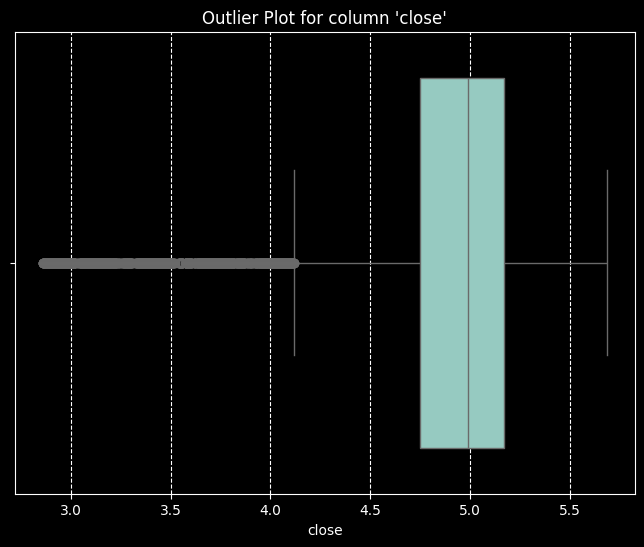

***************************************************************************

Outliers in column 'volume':
Outlier Count: 5328
Outlier Percentage of total observations: 7.60%
Outlier Values: 597410.0, 722723.0, 647146.0, 1073244.0, 640070.0, 1323727.0, 1538583.0, 603122.0, 618185.0, 1509206.0, 2914162.0, 2000159.0, 926290.0, 992746.0, 888859.0, 1619144.0, 828857.0, 1588402.0, 961970.0, 815029.0, 616985.0, 640759.0, 620594.0, 726041.0, 956421.0, 1737914.0, 743365.0, 616598.0, 606169.0, 1444357.0, 1460780.0, 641772.0, 1861928.0, 1216224.0, 878039.0, 681470.0, 1168036.0, 952950.0, 746607.0, 1918952.0, 610655.0, 835003.0, 2683564.0, 4051178.0, 1345993.0, 834071.0, 1315058.0, 725839.0, 666178.0, 1903306.0, 736691.0, 2292509.0, 877984.0, 1320494.0, 621611.0, 637272.0, 1499776.0, 1122896.0, 668386.0, 619407.0, 660297.0, 755580.0, 1286130.0, 971870.0, 1828704.0, 692160.0, 825855.0, 1024756.0, 633078.0, 698531.0, 687395.0, 654763.0, 678055.0, 824000.0, 652823.0, 2369675.0, 995262.0, 1538606.0, 2

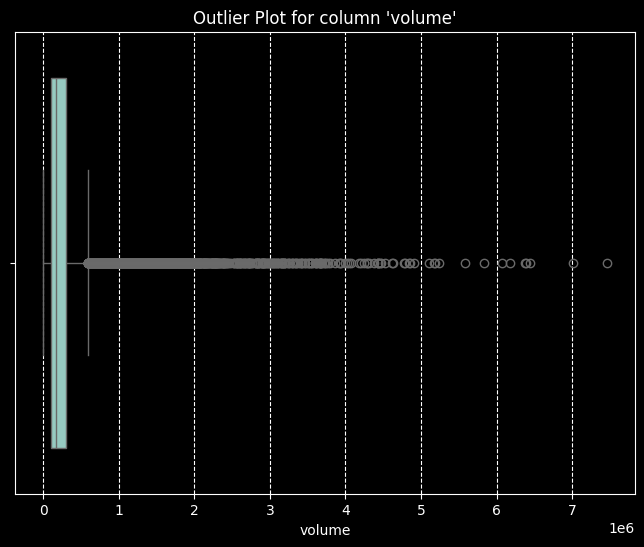

***************************************************************************

No outliers in column 'doji' as it has binary values.
***************************************************************************

No outliers in column 'hammer' as it has binary values.
***************************************************************************

No outliers in column 'inverted_hammer' as it has binary values.
***************************************************************************

No outliers in column 'bullish_engulfing' as it has binary values.
***************************************************************************

No outliers in column 'bearish_engulfing' as it has binary values.
***************************************************************************

No outliers in column 'piercing_line' as it has binary values.
***************************************************************************

No outliers in column 'dark_cloud' as it has binary values.
*****************************

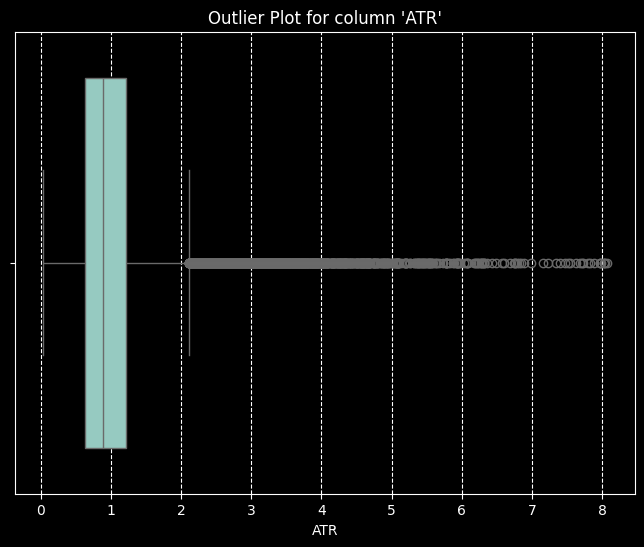

***************************************************************************

Outliers in column 'historical_volatility':
Outlier Count: 3618
Outlier Percentage of total observations: 5.16%
Outlier Values: 1.382090005032974, 1.5053673694834453, 1.5682232514875545, 1.5311315125195526, 1.471556537827637, 1.4215253903881595, 1.383407079419132, 1.3803647111776884, 1.3735977387063014, 1.5856531129033413, 1.8973792577450965, 1.8990755768477707, 1.9016087602656697, 1.8385063420278767, 1.8778534691515667, 1.846420627285511, 1.8122422261110054, 1.8194827089138905, 1.828828394233633, 1.8342085141870228, 1.7643262771542854, 1.703985200776959, 1.6768259318682013, 1.6590912351675615, 1.6722164453958102, 1.6846209952618862, 1.6797931763014515, 1.6406588125959853, 1.7418575787214774, 1.7174278012287845, 1.6724698697370897, 1.5842361156996216, 1.6027570126162392, 1.5344740255491092, 1.4571917473460485, 1.4478439989268699, 1.4016333091204027, 1.4985369342956527, 1.4393373444412352, 1.4877525582341546, 1

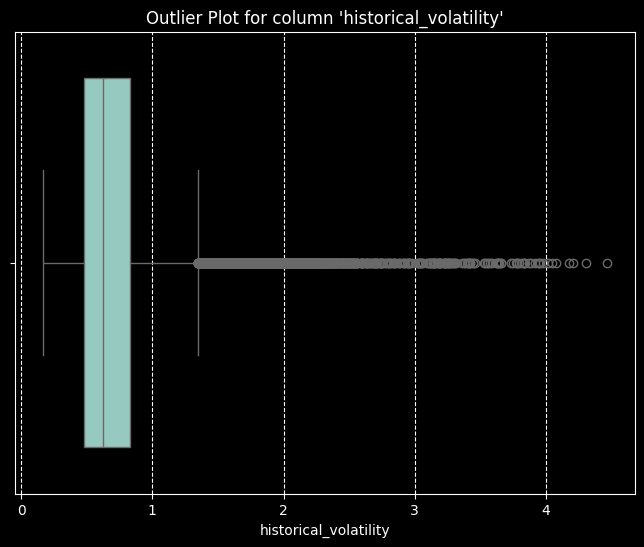

***************************************************************************

Outliers in column 'SMA_10':
Outlier Count: 8730
Outlier Percentage of total observations: 12.46%
Outlier Values: 2.9619686434011814, 2.9629507840296108, 2.9639319610041928, 2.9646646335890936, 2.9655153047683562, 2.9664630793719837, 2.9667770890985694, 2.9669314839482643, 2.9675591108703965, 2.9680989663564854, 2.9687361348834194, 2.969301025412389, 2.9703221536167757, 2.971362733769979, 2.971808365434617, 2.972064385753788, 2.9728013582632693, 2.973440651278135, 2.9735786849125496, 2.9737627001249933, 2.973864916168912, 2.973527563565798, 2.972801358263269, 2.971946624547777, 2.97147031821747, 2.9712295179396424, 2.9710706604831287, 2.9710962843604842, 2.9714754409977053, 2.9715420347527726, 2.971378103685419, 2.97146007257827, 2.971793002130892, 2.9724329398995866, 2.9729190188637293, 2.9733588445770978, 2.973471327065738, 2.9735480124181066, 2.97360935646622, 2.9737013654831683, 2.973834252452774, 2.974053

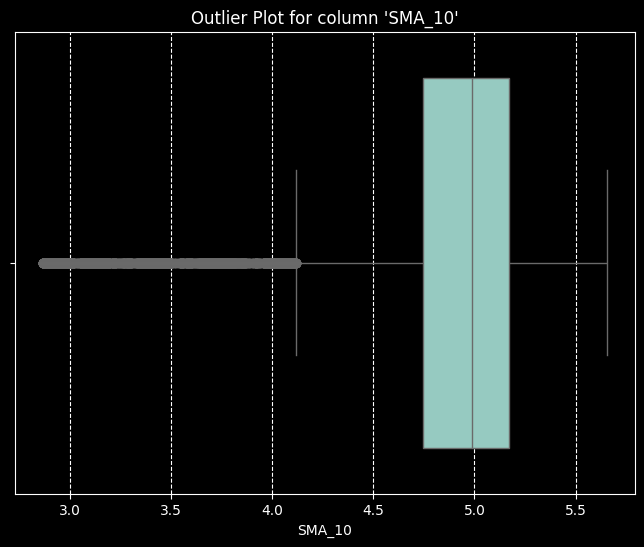

***************************************************************************

Outliers in column 'SMA_30':
Outlier Count: 8768
Outlier Percentage of total observations: 12.51%
Outlier Values: 2.9587362838672657, 2.959332777023984, 2.959756157664187, 2.9602691584449388, 2.960749102656322, 2.9611391034550723, 2.961615181409753, 2.9619996731224867, 2.9624960177612967, 2.9628698369835753, 2.963307217528836, 2.9636187775260203, 2.964016262877208, 2.9645459976954083, 2.964999832868203, 2.9655153047683576, 2.966147254302118, 2.9666449768029275, 2.9671716063432334, 2.9676808180277, 2.968201762937563, 2.968602568665201, 2.9690254671698715, 2.9693301171926807, 2.9696021699349475, 2.9699220366541743, 2.9702195747848545, 2.9704930949569626, 2.9708741889405466, 2.9711372811986094, 2.9713285775565343, 2.9714310426971293, 2.9716393561105345, 2.971914195113797, 2.972066092335991, 2.9722179664889232, 2.972448293374975, 2.972695622435609, 2.9728883261286985, 2.973002566536678, 2.9730264360183534, 2.97301

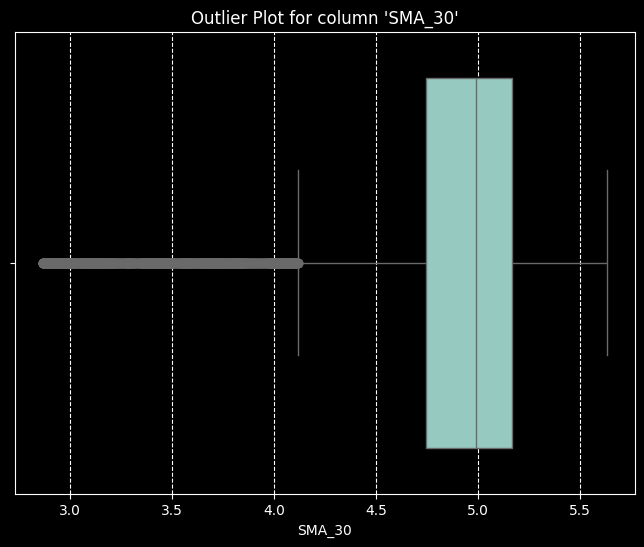

***************************************************************************

Outliers in column 'SMA_50':
Outlier Count: 8772
Outlier Percentage of total observations: 12.52%
Outlier Values: 2.962840212171484, 2.9624691387365485, 2.962096893348093, 2.961717267166706, 2.961532056592618, 2.9613530215907975, 2.9612163952873303, 2.9611014905365134, 2.9611087371721334, 2.9612298517368254, 2.9612629745333865, 2.961276430356109, 2.961475141425694, 2.961716232566038, 2.9618372735809855, 2.961892099305022, 2.9621020643719507, 2.962332664849374, 2.9628154093282495, 2.963314448198029, 2.9637822646552143, 2.9641838132549574, 2.964495444212133, 2.964838951236516, 2.965119446022905, 2.9653555368952746, 2.9657564543729684, 2.9661201298898185, 2.9665207410073458, 2.9667945883792988, 2.967043662586174, 2.96717846613593, 2.967336914250163, 2.967610538236967, 2.967884087374165, 2.9682325998514063, 2.9686015411636064, 2.9689200161028344, 2.9693236143975903, 2.9696603351309627, 2.9699661599675546, 2.970266

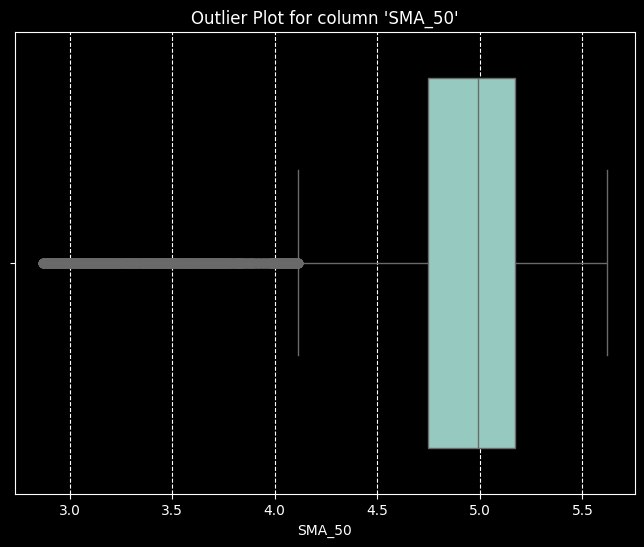

***************************************************************************

Outliers in column 'SMA_100':
Outlier Count: 8691
Outlier Percentage of total observations: 12.40%
Outlier Values: 2.9748405534114384, 2.9746419275037885, 2.9744064868392384, 2.974182230415638, 2.974018220647237, 2.9738705377482137, 2.973701876620728, 2.973529097244226, 2.973386966385435, 2.973227939933785, 2.9730693996496456, 2.972933341817696, 2.972835634736797, 2.972728197083786, 2.9725721361235005, 2.97240837384864, 2.9722783684486265, 2.9721283805932663, 2.971965569677817, 2.9718017080319825, 2.971654721774933, 2.9714621217145085, 2.97127512074079, 2.9710639981674674, 2.970861032510507, 2.9706821220542, 2.9705380476767074, 2.970414978390082, 2.9703170249250794, 2.970197006029653, 2.9700692777941273, 2.969922036654174, 2.9697973521174346, 2.96970600954578, 2.9696151718606005, 2.969513033761076, 2.969376491163166, 2.969228634544799, 2.969091539606853, 2.968955453010377, 2.9688142114868805, 2.968682196827411

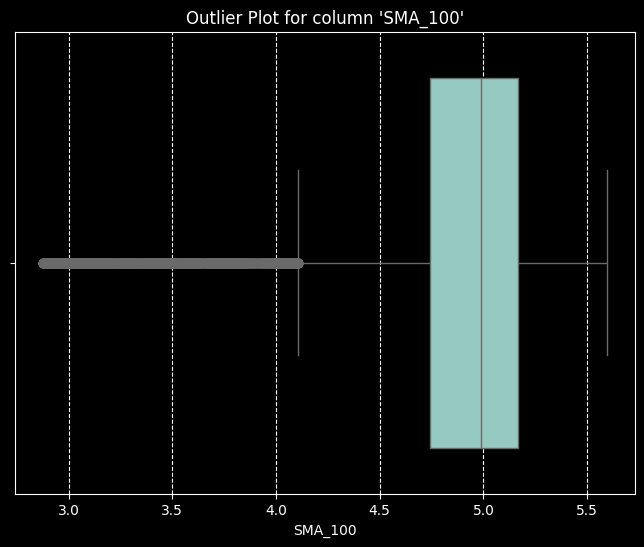

***************************************************************************

Outliers in column 'SMA_200':
Outlier Count: 8691
Outlier Percentage of total observations: 12.40%
Outlier Values: 2.9748405534114384, 2.9746419275037885, 2.9744064868392384, 2.974182230415638, 2.974018220647237, 2.9738705377482137, 2.973701876620728, 2.973529097244226, 2.973386966385435, 2.973227939933785, 2.9730693996496456, 2.972933341817696, 2.972835634736797, 2.972728197083786, 2.9725721361235005, 2.97240837384864, 2.9722783684486265, 2.9721283805932663, 2.971965569677817, 2.9718017080319825, 2.971654721774933, 2.9714621217145085, 2.97127512074079, 2.9710639981674674, 2.970861032510507, 2.9706821220542, 2.9705380476767074, 2.970414978390082, 2.9703170249250794, 2.970197006029653, 2.9700692777941273, 2.969922036654174, 2.9697973521174346, 2.96970600954578, 2.9696151718606005, 2.969513033761076, 2.969376491163166, 2.969228634544799, 2.969091539606853, 2.968955453010377, 2.9688142114868805, 2.968682196827411

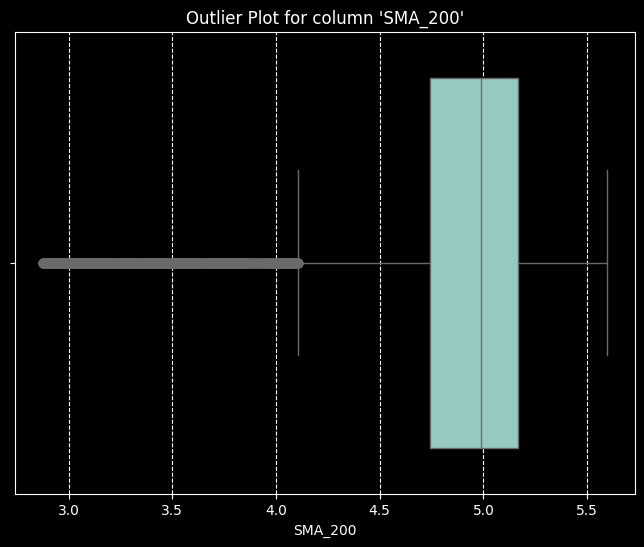

***************************************************************************

Outliers in column 'EMA_10':
Outlier Count: 8731
Outlier Percentage of total observations: 12.46%
Outlier Values: 2.9627592086282437, 2.96364865332628, 2.964122487680307, 2.9645100034055094, 2.9654362208829004, 2.9663338394941454, 2.966552983776868, 2.9665825022293024, 2.9673364340120725, 2.9678126501087774, 2.968631874856805, 2.9694789885263817, 2.970749610085489, 2.9718252541810855, 2.97222991749898, 2.9723561745742577, 2.9728222916199423, 2.9728780141911235, 2.9727375729052143, 2.9725668295108107, 2.9727062275938767, 2.972196864337984, 2.9716495530082714, 2.9710058606287206, 2.970693310275411, 2.9706612606118177, 2.971147613417747, 2.9715546760052236, 2.972343703890073, 2.972365512728255, 2.9722437611849863, 2.9719672695989243, 2.9720668469524387, 2.9725112525073767, 2.9728096004047755, 2.97319311882398, 2.9734231367674764, 2.9735555268684912, 2.9740912546718343, 2.973962774595745, 2.973792596416403, 2.9736

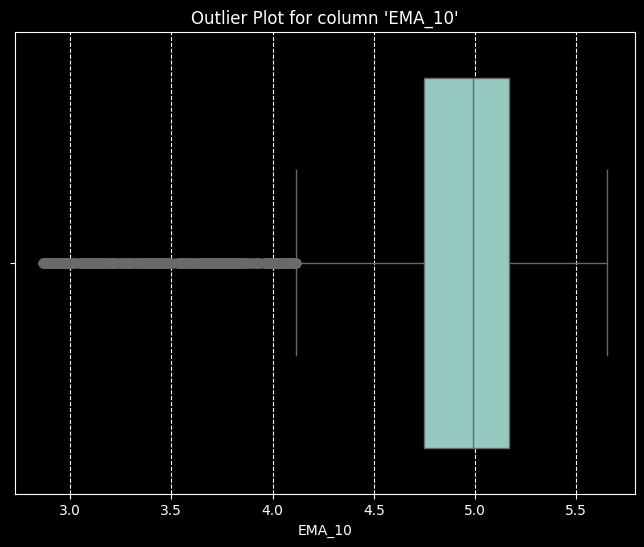

***************************************************************************

Outliers in column 'EMA_30':
Outlier Count: 8774
Outlier Percentage of total observations: 12.52%
Outlier Values: 2.9618015117408407, 2.9621793092049753, 2.962442562523187, 2.9626887690322907, 2.9631356846557373, 2.963603554474384, 2.9638578922520544, 2.9640424893150423, 2.964474781647692, 2.964829110530953, 2.965313447776683, 2.965829477933378, 2.966517925130329, 2.967174804692041, 2.967619722134337, 2.967962792659259, 2.9684129222237665, 2.968717839733565, 2.9689367349524773, 2.9691215879296498, 2.969393845852135, 2.969426606383398, 2.9694108876548087, 2.9693266307019672, 2.9693239851292947, 2.969400998372609, 2.9696551610251154, 2.9698961778598725, 2.970283744436959, 2.9704245267777467, 2.9705065864575784, 2.970520492639547, 2.9706492791679153, 2.9708987199805277, 2.9711088682303552, 2.9713550009221934, 2.9715554569766893, 2.9717231190530025, 2.9720318962547587, 2.972119210423049, 2.9721777659505064, 2.9722

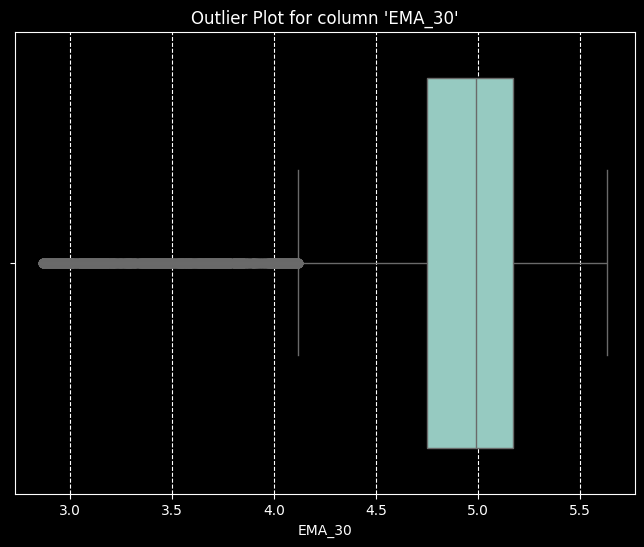

***************************************************************************

Outliers in column 'EMA_50':
Outlier Count: 8795
Outlier Percentage of total observations: 12.55%
Outlier Values: 2.9645678430692493, 2.9646885525881457, 2.9647499090750027, 2.964808855879267, 2.964996925460068, 2.96520791029488, 2.9652994099092504, 2.9653549737559266, 2.965565993280915, 2.9657383887532185, 2.9659969183101906, 2.9662836155705232, 2.966684151988649, 2.967076901208367, 2.967351229785906, 2.9675703611458877, 2.967859489008739, 2.968066649713681, 2.968225337503319, 2.9683656874875965, 2.9685609605797785, 2.9686135651523076, 2.9686358996202173, 2.968615050312411, 2.9686413557746967, 2.9687149777235535, 2.968896489942333, 2.9690728667691006, 2.969340950249859, 2.9694635928097393, 2.9695512201825944, 2.969597163289036, 2.9697117418069654, 2.969900289474501, 2.970067327421289, 2.970257959671954, 2.9704229826939597, 2.970569444155059, 2.970802619000331, 2.9709039913749944, 2.9709873094185912, 2.9710633

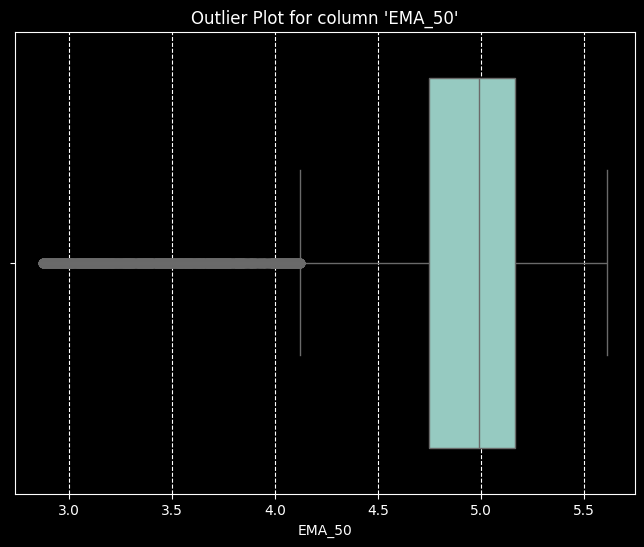

***************************************************************************

Outliers in column 'EMA_100':
Outlier Count: 8612
Outlier Percentage of total observations: 12.29%
Outlier Values: 2.9748458055502573, 2.9747036464838423, 2.974536977878057, 2.974373582677499, 2.9742791512710207, 2.974201755965995, 2.974070241045457, 2.9739251228855967, 2.9738617963624128, 2.973784539007938, 2.9737553633555485, 2.9737459948623797, 2.9737995611438355, 2.973856111919414, 2.9738599294444863, 2.9738414073423254, 2.973862720091425, 2.973848190808836, 2.9738137084319782, 2.973773835255947, 2.973765113245344, 2.9736887510104677, 2.9735997237457714, 2.973491192232095, 2.973408085062488, 2.9733509173777906, 2.9733505680982897, 2.9733512382438954, 2.973401506761641, 2.9733829438072985, 2.9733495605673377, 2.9732975987957277, 2.9732821042176996, 2.9733064066032604, 2.973323139448254, 2.9733547283646886, 2.9733765784874873, 2.9733919206871304, 2.9734535305539835, 2.9734521618743317, 2.973443733418068, 2.9

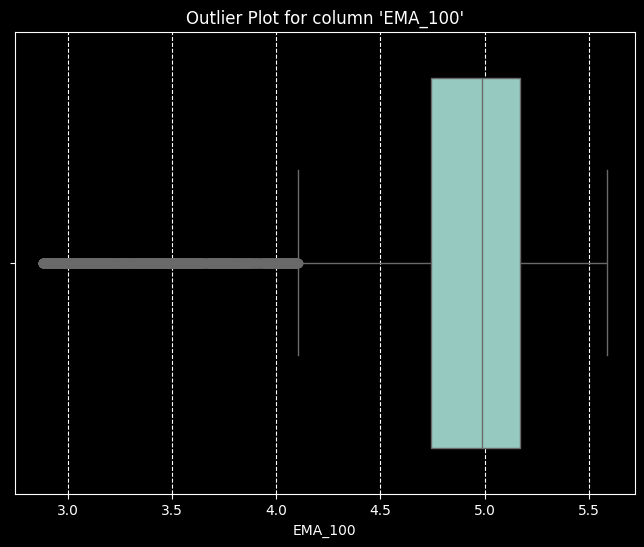

***************************************************************************

Outliers in column 'EMA_200':
Outlier Count: 8691
Outlier Percentage of total observations: 12.40%
Outlier Values: 2.9748405534114384, 2.9746419275037885, 2.9744064868392384, 2.974182230415638, 2.974018220647237, 2.9738705377482137, 2.973701876620728, 2.973529097244226, 2.973386966385435, 2.973227939933785, 2.9730693996496456, 2.972933341817696, 2.972835634736797, 2.972728197083786, 2.9725721361235005, 2.97240837384864, 2.9722783684486265, 2.9721283805932663, 2.971965569677817, 2.9718017080319825, 2.971654721774933, 2.9714621217145085, 2.97127512074079, 2.9710639981674674, 2.970861032510507, 2.9706821220542, 2.9705380476767074, 2.970414978390082, 2.9703170249250794, 2.970197006029653, 2.9700692777941273, 2.969922036654174, 2.9697973521174346, 2.96970600954578, 2.9696151718606005, 2.969513033761076, 2.969376491163166, 2.969228634544799, 2.969091539606853, 2.968955453010377, 2.9688142114868805, 2.968682196827411

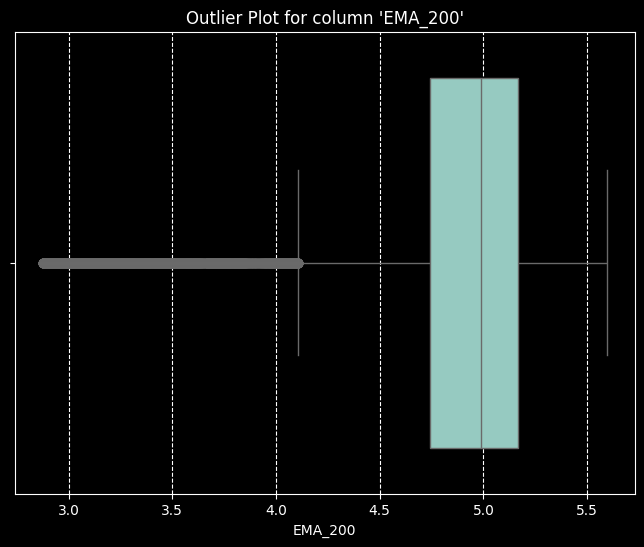

***************************************************************************

Outliers in column 'RSI_14':
Outlier Count: 439
Outlier Percentage of total observations: 0.63%
Outlier Values: 16.037714814279923, 8.90740299435554, 14.523185457696838, 14.327725621284305, 12.883661830996779, 19.161795625789622, 82.37469696412168, 85.22441693683257, 81.40331372300491, 82.28046133540995, 82.63972016174812, 83.35026708844198, 83.55258354350471, 86.49749207127458, 80.95588675593832, 93.15727708102895, 84.14833758025534, 82.31139844306657, 85.08880918153908, 82.42749036988866, 82.65523771234118, 82.99576153650976, 85.06005929881456, 85.7090595255829, 14.042791622112691, 15.779547599515176, 15.665922077769064, 14.082443980628161, 13.144976525515304, 13.11199378594663, 12.083471142976588, 16.45252303178625, 15.220240551168068, 14.301307163817667, 82.76777553745231, 84.61643961398474, 84.76622553610032, 82.18104005556151, 88.38061451452445, 81.05699511150698, 81.18812296694982, 82.96590262211103, 85

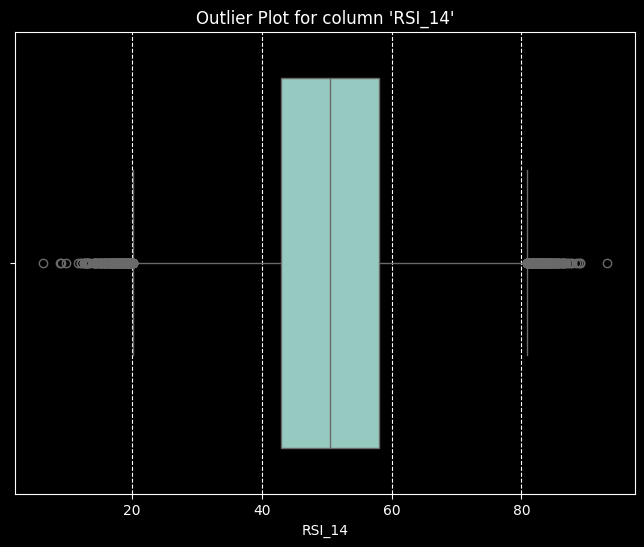

***************************************************************************

Outliers in column 'MACD':
Outlier Count: 5131
Outlier Percentage of total observations: 7.32%
Outlier Values: 1.5451702807363645, 1.7882753194266527, 1.880505474304492, 1.9759278979346604, 1.9589291939647353, 1.8380905604388431, 1.7424923084121318, 1.761889776956309, 1.7233448901808757, 1.6782929715940753, 1.5661948248768454, 1.5282191412126451, 1.7179330220905484, 1.8225016407602226, 1.7114314515041684, 1.6522119989359823, 1.5518866500699033, 1.4664478536640502, 1.4540334364951946, 1.5023781961283476, 1.527121141755245, 1.6400665134942187, 1.70539902396213, 1.6557034236283101, 1.5257059769436552, 1.4953074712427679, 1.5751915577130546, 1.6813321775092902, 1.7744471112241769, 1.7975833457731767, 1.8204327221774008, 1.7834465330675755, 1.6736773360947268, 1.5935712434681903, 1.5470314701172754, 1.4933375568637928, 1.7703254901328336, 2.03372894280767, 2.2776293237602374, 2.4231395444636803, 2.489586132827199, 

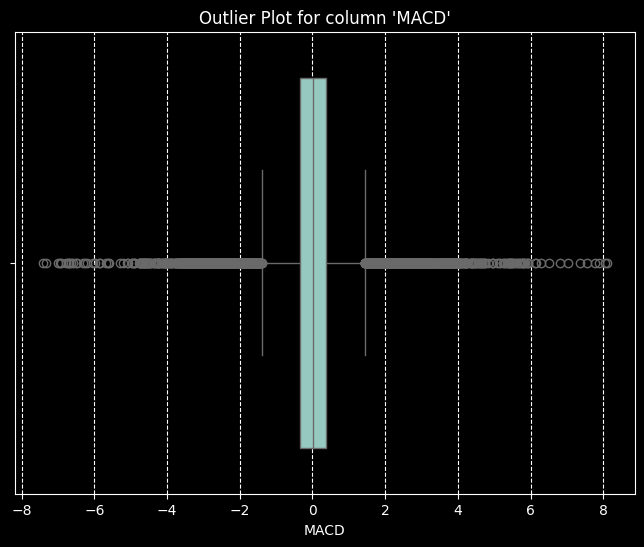

***************************************************************************

Outliers in column 'MACD_signal':
Outlier Count: 4973
Outlier Percentage of total observations: 7.10%
Outlier Values: 1.4653111542226978, 1.5398670354659267, 1.5803920900551678, 1.616691627435396, 1.638022279984492, 1.6460764183064085, 1.630100099620496, 1.570497523505529, 1.4680986874114146, 1.4090794767266968, 1.4376409113953381, 1.4434022998490805, 1.4455285271783034, 1.4449377150431553, 1.4430989601418833, 1.4324670614044934, 1.4152116915665278, 1.4362338792449771, 1.4541282987847128, 1.442203309205075, 1.4243381120887946, 1.4069492781611421, 1.3873723958666453, 1.3922754869123775, 1.477906933965382, 1.5390148537858208, 1.565947350247602, 1.5714721288917197, 1.566583997136831, 1.5519347090822233, 1.525239109765512, 1.5742563858389764, 1.6661508972327153, 1.7884465825382196, 1.9153851749233117, 2.030225366504089, 2.1229262760471515, 2.189579664779022, 2.249307296636386, 2.2841674049157557, 2.304289008626943

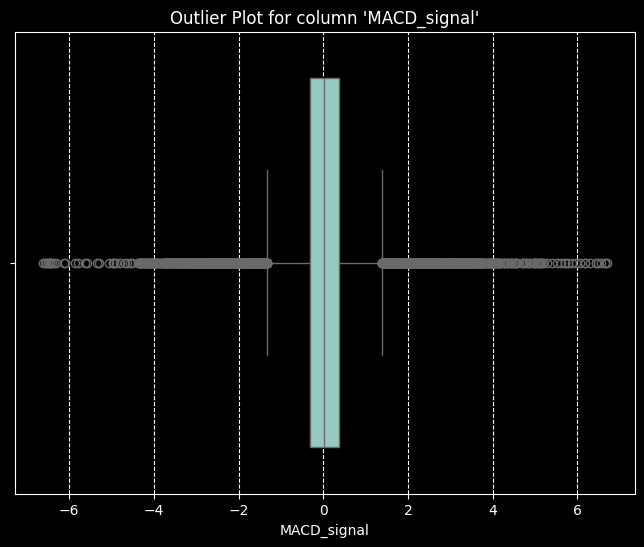

***************************************************************************

Outliers in column 'bollinger_high':
Outlier Count: 8776
Outlier Percentage of total observations: 12.52%
Outlier Values: 2.967370603787087, 2.968084728535818, 2.968371475308872, 2.968998938697338, 2.970261259901008, 2.9714801888312183, 2.971866277915878, 2.9721847422684977, 2.9728781053154845, 2.973225877234519, 2.9739595710436824, 2.9746680088852675, 2.9755918934841445, 2.9765726489088644, 2.9769864909035335, 2.97697691365469, 2.9775366282486115, 2.9777597199591948, 2.9777079922242597, 2.9775313965340455, 2.9775629635303735, 2.9774877044989454, 2.977262665993519, 2.97706329190467, 2.9770728064953413, 2.9770736981484367, 2.97706772401044, 2.976841864231701, 2.9772990214785895, 2.977277497069796, 2.977263639672048, 2.9771966954894755, 2.9766388097387773, 2.976189287377207, 2.976204091515095, 2.9764662633140175, 2.9763901523599237, 2.976506982593929, 2.9771008535672285, 2.9771804269547237, 2.977157574692401, 2.

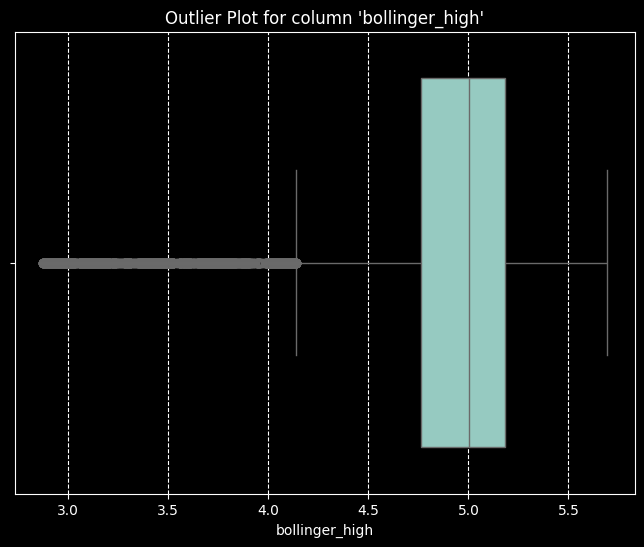

***************************************************************************

Outliers in column 'bollinger_mid':
Outlier Count: 8769
Outlier Percentage of total observations: 12.51%
Outlier Values: 2.9605816662709676, 2.9607654995579975, 2.9608483429503782, 2.9611201246362953, 2.9615781037661444, 2.962224609811513, 2.9628035244145194, 2.963229742792017, 2.9639526070179647, 2.964625949518029, 2.965358113998996, 2.966130945408233, 2.967132161622003, 2.9680192917373076, 2.968666785419887, 2.9692676543869068, 2.969793760151431, 2.9701913637612662, 2.970573427293591, 2.970934842970405, 2.9713038135722467, 2.971416527440527, 2.971562524246786, 2.971654721774933, 2.971639356110534, 2.9716470389722462, 2.9719363837875035, 2.9722691548261833, 2.9725276159093967, 2.9726529838580937, 2.9726222829565083, 2.9724943523868124, 2.972297307294837, 2.9721898117865098, 2.9721949308822726, 2.972294748012255, 2.972271714174266, 2.972322899760416, 2.9725429679312585, 2.972622282956508, 2.9726069321522535, 2

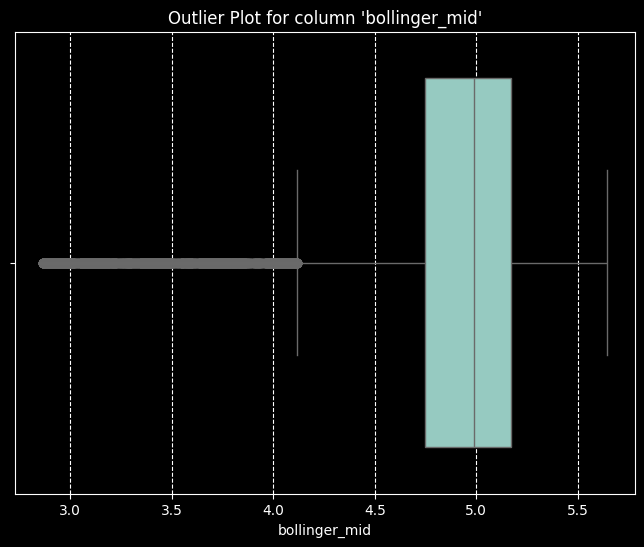

***************************************************************************

Outliers in column 'bollinger_low':
Outlier Count: 8458
Outlier Percentage of total observations: 12.07%
Outlier Values: 2.953746323862889, 2.9533923042325965, 2.9532681837801453, 2.953178741568436, 2.9528188895243357, 2.952882564126733, 2.9536578856711264, 2.9541938261410303, 2.9549467262081692, 2.95595142101971, 2.9566820295222676, 2.9575203724731796, 2.958600251655134, 2.9593921430277037, 2.9602772813270515, 2.9614985003977843, 2.9619904719185253, 2.9625652904464967, 2.9633875943521883, 2.964294485774948, 2.9650052397666293, 2.9653082659303562, 2.965829704526049, 2.966216739866593, 2.966176221984079, 2.966190770413153, 2.966778577044994, 2.9676754396593457, 2.967733334837189, 2.9680069851254016, 2.967959283558364, 2.9677697927425624, 2.9679368739891787, 2.9681742761375074, 2.9681696321585687, 2.968105758250154, 2.9681362442873374, 2.968121236795264, 2.9679642128168267, 2.9680432671083836, 2.968035486561266,

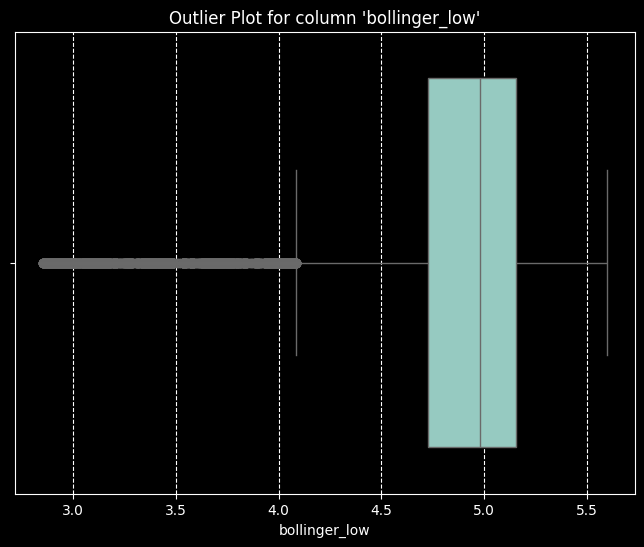

***************************************************************************

Outliers in column 'volume_mean_10':
Outlier Count: 4821
Outlier Percentage of total observations: 6.88%
Outlier Values: 789628.6, 968537.0, 1003180.4, 1042142.8, 1085481.7, 1185577.6, 1221101.4, 1354623.8, 1422979.5, 1324831.0, 1090562.4, 972049.4, 941118.9, 890574.0, 844376.8, 708343.3, 646061.0, 606664.4, 735104.7, 767713.4, 780634.0, 789949.0, 721603.3, 605932.6, 609492.9, 607120.8, 648877.9, 720800.5, 780180.3, 778093.6, 772908.5, 779581.0, 774250.0, 641333.2, 590720.5, 795175.6, 912621.1, 971831.0, 1093377.4, 1156187.2, 1203379.5, 1244536.6, 1277780.3, 1296546.3, 1069837.5, 695274.2, 601506.0, 711117.4, 760977.5, 870500.6, 908499.9, 933552.4, 951902.1, 993515.1, 1076874.9, 998833.9, 992003.4, 807159.0, 781301.3, 715281.6, 688417.2, 670334.7, 661298.0, 618671.0, 688123.5, 677518.4, 683442.0, 694195.9, 706614.7, 754730.5, 753460.4, 699508.7, 603220.8, 655678.1, 734798.5, 733333.4, 857559.7, 1078612.7, 1120

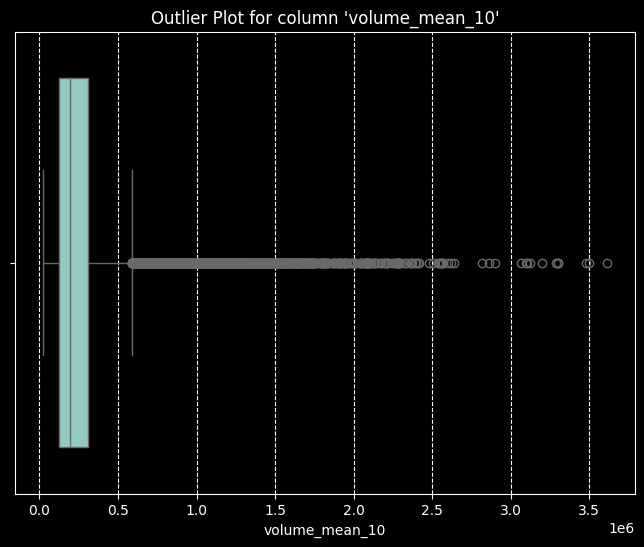

***************************************************************************

Outliers in column 'volume_mean_30':
Outlier Count: 4266
Outlier Percentage of total observations: 6.09%
Outlier Values: 581207.5666666667, 620569.9666666667, 638481.3, 685591.9, 666371.4666666667, 678073.5, 692070.8333333334, 714939.8333333334, 731226.2333333333, 737449.7666666667, 746225.6666666666, 742686.6333333333, 741018.2666666667, 744798.7333333333, 749450.6333333333, 751447.3333333334, 751496.3666666667, 749129.3666666667, 734273.6, 720207.2, 715308.9, 706262.9666666667, 702191.7, 702265.1666666666, 699621.6666666666, 656984.4, 581223.3666666667, 588199.1666666666, 589389.2, 591192.3333333334, 591010.3, 589800.7333333333, 588116.7666666667, 590847.3666666667, 590028.6333333333, 591098.4666666667, 590028.4666666667, 582844.8333333334, 583016.5333333333, 591631.3333333334, 596822.2, 578451.3333333334, 591050.2666666667, 594516.4, 600240.2, 606330.2333333333, 619494.2333333333, 615853.1, 616442.166666666

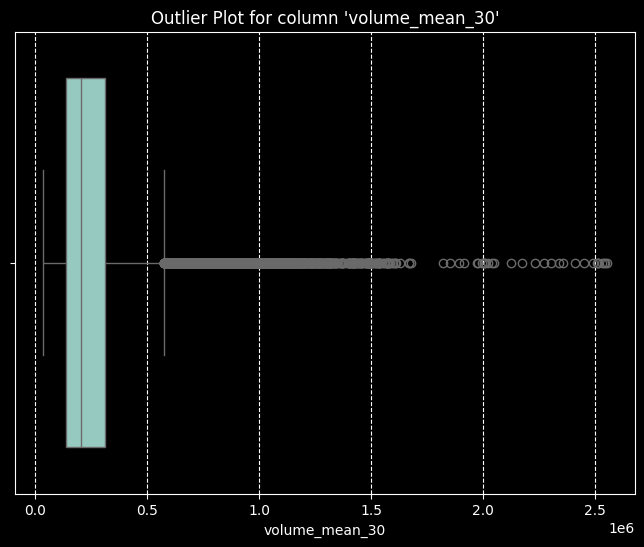

***************************************************************************

Outliers in column 'parabolic_SAR':
Outlier Count: 8703
Outlier Percentage of total observations: 12.42%
Outlier Values: 2.958813889585068, 2.9593095447054907, 2.9597851426024464, 2.9602415038792715, 2.9606794148557243, 2.9610996290565077, 2.9615028686307365, 2.9618898257059048, 2.962261163679683, 2.962804949551837, 2.9633158387902707, 2.9641911186423955, 2.965248293271164, 2.9667779683947555, 2.9681221496530985, 2.969303536402086, 2.970342003492459, 2.9712549633194043, 2.9779246549040264, 2.977802491388008, 2.9775283835959487, 2.9772651694096224, 2.9767667861967735, 2.9761295574775595, 2.975253355707896, 2.9742571539349605, 2.9669211916998712, 2.967085854963869, 2.967247198660867, 2.9676723792284934, 2.9680803825673414, 2.9684719092229086, 2.968847630649021, 2.96920819045711, 2.969388298214389, 2.9697270498664765, 2.970052143528741, 2.970364134046681, 2.970663553396035, 2.970950911651436, 2.9713983759660643, 

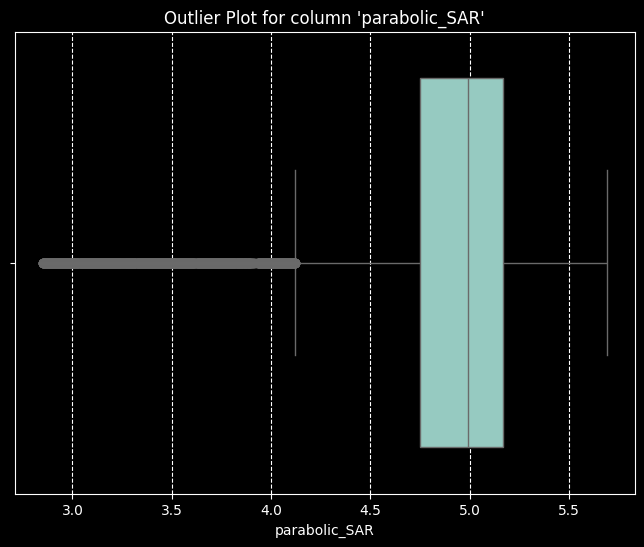

***************************************************************************

Outliers in column 'ADX':
Outlier Count: 1501
Outlier Percentage of total observations: 2.14%
Outlier Values: 54.856199734859565, 56.42338262941336, 57.87862388864188, 57.11367158282985, 55.74272137525316, 54.39187536399528, 53.64056866088375, 54.78028260992681, 57.52812699669336, 60.07969678440516, 61.428459833815964, 62.48051372125928, 62.6151483023756, 62.74016612769791, 62.62499661215611, 62.51805349058158, 61.35573071854865, 60.276431001660924, 59.38032800127311, 58.70777267130057, 58.37383149076107, 58.06374325168868, 58.02737618209777, 58.14827848122908, 58.59227365074814, 58.44644826226176, 58.423097140085325, 58.63715317042346, 58.938274197045985, 58.26395477789627, 57.637801031542956, 57.33077880975092, 56.75943586074296, 56.22890312237843, 55.73626557961137, 55.303517343652246, 54.10194122062507, 54.17366698884842, 56.6428270456234, 58.93561852691444, 60.421928612498895, 61.80207369197018, 62.282497

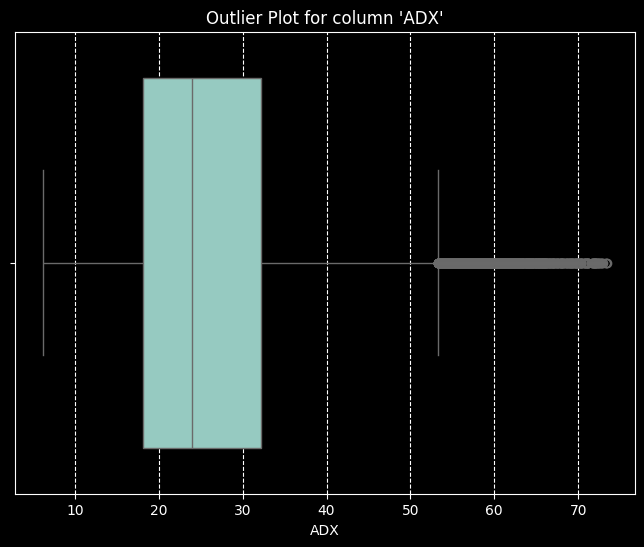

***************************************************************************

Outliers in column 'CCI':
Outlier Count: 69
Outlier Percentage of total observations: 0.10%
Outlier Values: -343.7714191337489, -334.6228819912972, -412.2405013709303, -349.9902256478971, -363.3417028075761, 348.10766910314203, 348.61411087111253, 390.55171551554884, 366.6609001528125, 414.34478371501297, 380.992940454274, 386.8605333057524, 366.3343979970248, 353.25741750309965, 338.8074056263519, 466.66666666668254, 345.3961771253031, 352.1784704608654, -382.7753629271134, 407.72130556108215, -334.9438503050547, 349.4022932422429, 407.1483219713916, -341.6345259150278, -357.0239070542388, 340.7630522088413, 343.47707921104325, 349.7977847108702, 350.51015722026943, 391.30358723167836, 355.46724820289376, -335.7174121799324, 341.5044916326141, -385.3697498393207, 415.4883996535877, 419.9289631588338, 384.98317837551065, 379.73594386066856, -363.1167040165497, -359.8478674273286, 346.62906464983183, -361.70834

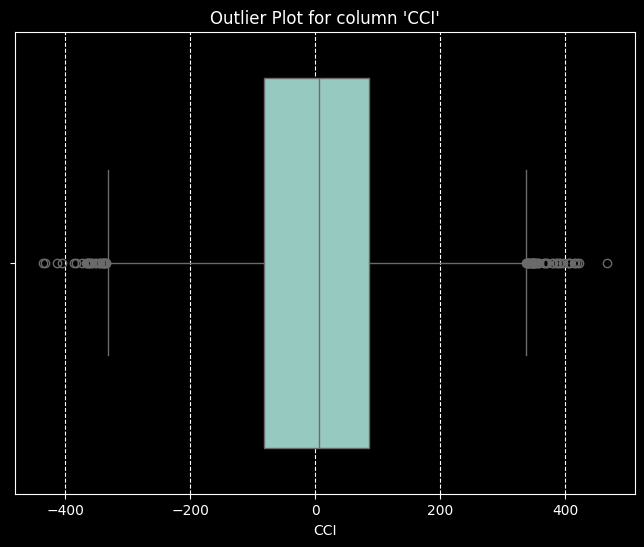

***************************************************************************

No outliers in column 'stochastic_oscillator_k'.
***************************************************************************

No outliers in column 'stochastic_oscillator_d'.
***************************************************************************

Outliers in column 'return':
Outlier Count: 3608
Outlier Percentage of total observations: 5.15%
Outlier Values: 0.011225635268905076, -0.010629557358529329, 0.013888182326906362, 0.012092323130958427, -0.01145208467601988, 0.011111111111111072, -0.010408245755861079, 0.010350198462543592, -0.018497290537724087, -0.028242289111854335, -0.011373046982830037, 0.009978933362900566, -0.01298196948682373, -0.012248567254747766, -0.011404494382022401, 0.027668869721070966, -0.012971441028994946, 0.01918228652855425, -0.012475801247580076, 0.009800100228297914, -0.021830029866956147, 0.01105367355917286, 0.01685790418184796, 0.01885677447082834, 0.015291326127076177, 0.

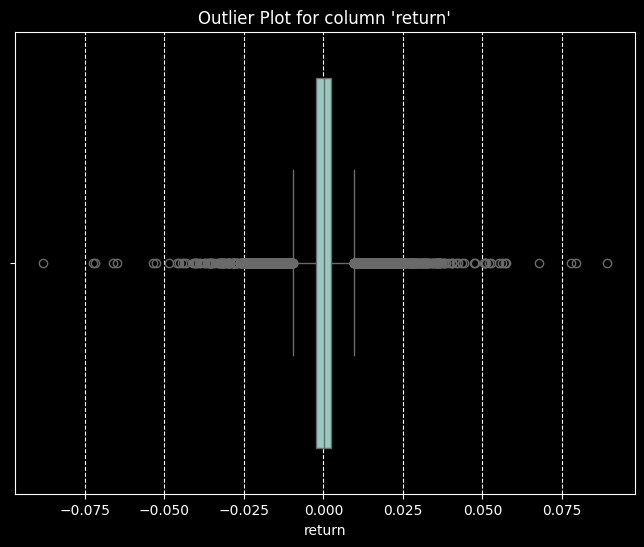

***************************************************************************

Outliers in column 'price_change':
Outlier Count: 3608
Outlier Percentage of total observations: 5.15%
Outlier Values: 0.011225635268905076, -0.010629557358529329, 0.013888182326906362, 0.012092323130958427, -0.01145208467601988, 0.011111111111111072, -0.010408245755861079, 0.010350198462543592, -0.018497290537724087, -0.028242289111854335, -0.011373046982830037, 0.009978933362900566, -0.01298196948682373, -0.012248567254747766, -0.011404494382022401, 0.027668869721070966, -0.012971441028994946, 0.01918228652855425, -0.012475801247580076, 0.009800100228297914, -0.021830029866956147, 0.01105367355917286, 0.01685790418184796, 0.01885677447082834, 0.015291326127076177, 0.01325345915283882, 0.016717406398547352, 0.010903106356716652, -0.010991768721140383, 0.009802925639983862, 0.010068122620717324, -0.010847491208083704, 0.012255023567353085, 0.015304145679968961, 0.012800380680466183, 0.05536681663759069, 0.0135

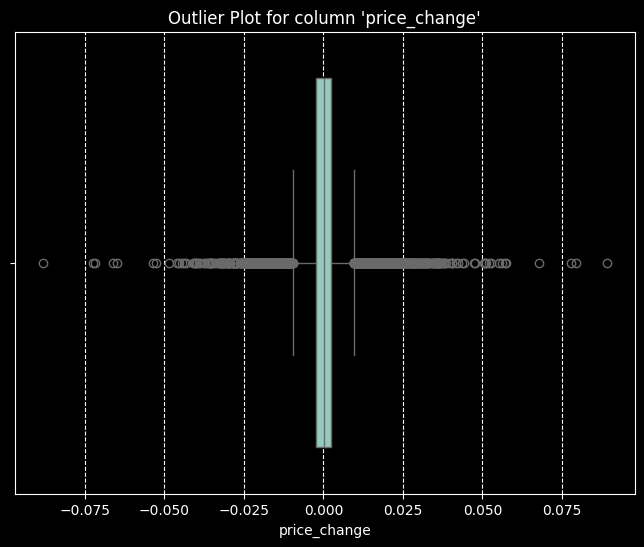

***************************************************************************

Outliers in column 'trade_signal':
Outlier Count: 14644
Outlier Percentage of total observations: 20.90%
Outlier Values: 1, 1, -1, -1, 1, -1, -1, 1, 1, -1, 1, -1, -1, -1, 1, -1, 1, 1, -1, 1, 1, 1, 1, -1, -1, -1, 1, -1, -1, -1, -1, -1, 1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, -1, -1, -1, 1, 1, 1, -1, -1, -1, 1, 1, -1, 1, -1, -1, -1, 1, 1, -1, -1, -1, 1, 1, -1, -1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, 1, 1, 1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, 1, -1, 1, -1, 1, 1, -1, 1, 1, 1, 1, 1, 1, -1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, -1, -1, 1, 1, -1, 1, -1, -1, -1, -1, -1, -1, 1, -1, 1, 1, 1, 1, -1, 1, -1, -1, 1, 1, 1, 1, 1, -1, -1, 1, -1, -1, -1, 1, 1, -1, -1, 1, -1, -1, -1, -1, -1, 1, -1, 1, 1, 1, 1, 1, -1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, -1, -1, 1, -1, -1, 1, 1, 1, 1, 1, -1, 1, 1, -1, 1, 1, 1, 1, -1, 1, 1, 1, 1, -1, 1, 1, 1, 1, -1, 1, -1, 1, 1, -1, -1, -1, -1, -1, -1, 1, -1, 1, 1

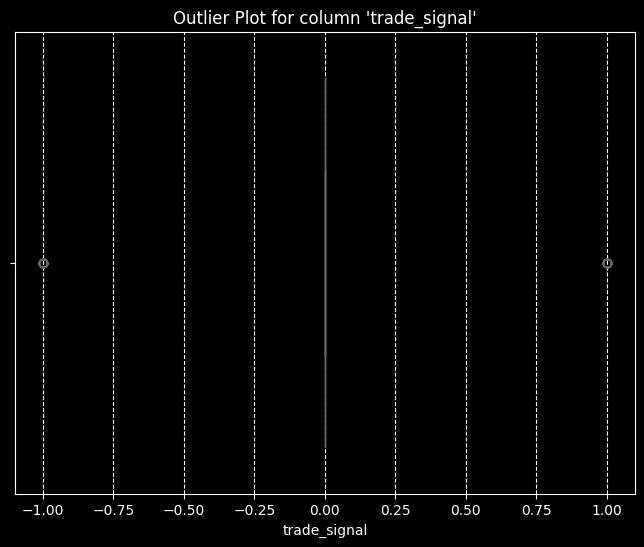

***************************************************************************



Column Outlier Count Outlier Percentage
0                      open          8713          12.433821
1                      high          8720           12.44381
2                       low          8697          12.410988
3                     close          8714          12.435248
4                    volume          5328           7.603282
5                      doji           NaN                NaN
6                    hammer           NaN                NaN
7           inverted_hammer           NaN                NaN
8         bullish_engulfing           NaN                NaN
9         bearish_engulfing           NaN                NaN
10            piercing_line           NaN                NaN
11               dark_cloud           NaN                NaN
12             morning_star           NaN                NaN
13             evening_star           NaN                NaN
14     three_white_soldiers           NaN                NaN
15        three_black_crows           NaN                NaN
16             harami_cross           NaN                NaN
17           bearish_harami           NaN                NaN
18                      ATR          3316           4.732073
19    historical_volatility          3618            5.16304
20                   SMA_10          8730          12.458081
21                   SMA_30          8768          12.512308
22                   SMA_50          8772          12.518016
23                  SMA_100          8691          12.402426
24                  SMA_200          8691          12.402426
25                   EMA_10          8731          12.459508
26                   EMA_30          8774           12.52087
27                   EMA_50          8795          12.550838
28                  EMA_100          8612           12.28969
29                  EMA_200          8691          12.402426
30                   RSI_14           439           0.626472
31                     MACD          5131           7.322155
32              MACD_signal          4973           7.096682
33           bollinger_high          8776          12.523725
34            bollinger_mid          8769          12.513735
35            bollinger_low          8458          12.069925
36           volume_mean_10          4821           6.879772
37           volume_mean_30          4266           6.087763
38            parabolic_SAR          8703           12.41955
39                      ADX          1501           2.141991
40                      CCI            69           0.098466
41  stochastic_oscillator_k             0                  0
42  stochastic_oscillator_d             0                  0
43                   return          3608           5.148769
44             price_change          3608           5.148769
45             trade_signal         14644           20.89761

In [51]:
 detect_outliers(df_stationary)

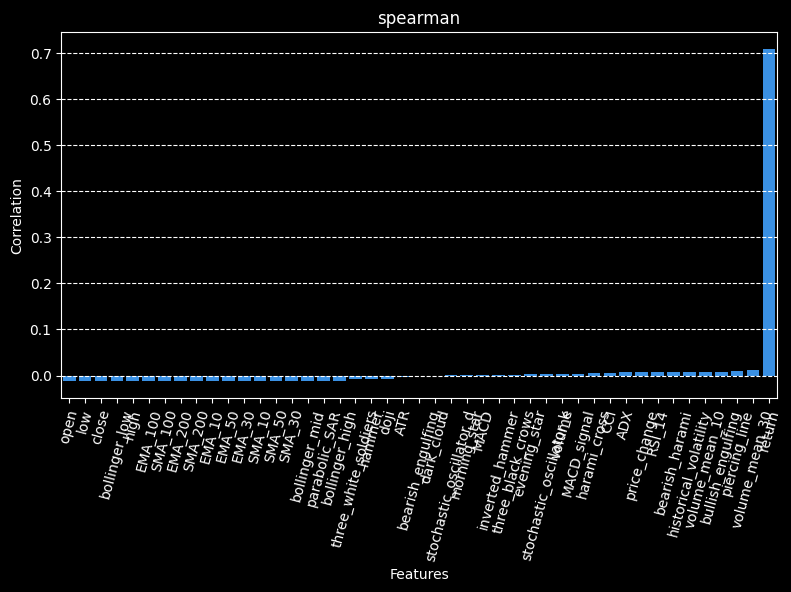

Correlation table with target feature 'trade_signal':


Correlation Type         spearman
Column                           
return                   0.709056
volume_mean_30           0.011370
piercing_line            0.009046
bullish_engulfing        0.008628
volume_mean_10           0.008624
historical_volatility    0.008292
bearish_harami           0.007424
RSI_14                   0.006768
price_change             0.006692
ADX                      0.006624
CCI                      0.005836
harami_cross             0.005834
MACD_signal              0.003368
volume                   0.003200
stochastic_oscillator_k  0.003064
evening_star             0.002789
three_black_crows        0.002161
inverted_hammer          0.001753
MACD                     0.001606
morning_star             0.001336
stochastic_oscillator_d  0.001159
dark_cloud              -0.000029
bearish_engulfing       -0.000046
ATR                     -0.002958
doji                    -0.006558
hammer                  -0.006885
three_white_soldiers    -0.006896
bollinger_high          -0.011869
parabolic_SAR           -0.012117
bollinger_mid           -0.012329
SMA_30                  -0.012380
SMA_50                  -0.012423
SMA_10                  -0.012465
EMA_30                  -0.012481
EMA_50                  -0.012485
EMA_10                  -0.012513
EMA_200                 -0.012517
SMA_200                 -0.012517
SMA_100                 -0.012517
EMA_100                 -0.012560
high                    -0.012588
bollinger_low           -0.012635
close                   -0.012665
low                     -0.012666
open                    -0.012706


Top 2 features with highest correlation (Spearman): ['return', 'open']


In [55]:
correlation_analysis(df_stationary, 'trade_signal', correlation_types=['spearman'])

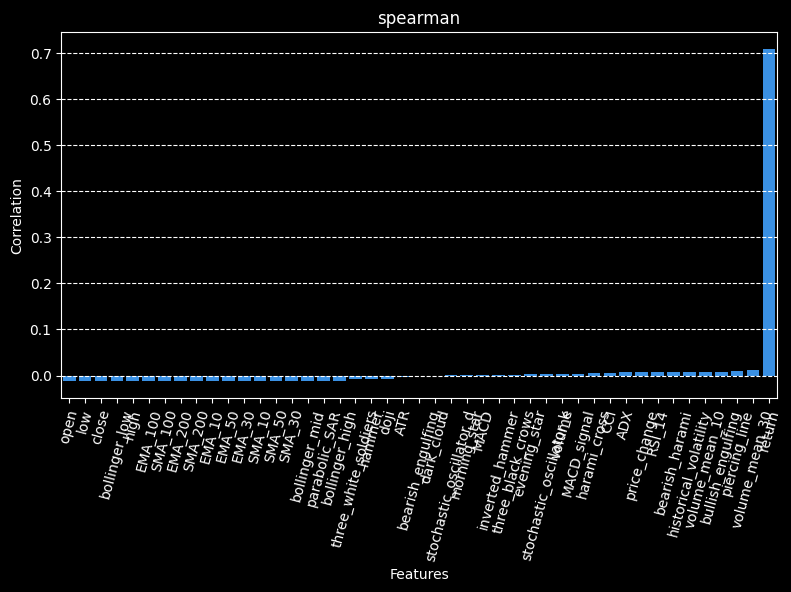

Correlation table with target feature 'trade_signal':


Correlation Type         spearman
Column                           
return                   0.709056
volume_mean_30           0.011370
piercing_line            0.009046
bullish_engulfing        0.008628
volume_mean_10           0.008624
historical_volatility    0.008292
bearish_harami           0.007424
RSI_14                   0.006768
price_change             0.006692
ADX                      0.006624
CCI                      0.005836
harami_cross             0.005834
MACD_signal              0.003368
volume                   0.003200
stochastic_oscillator_k  0.003064
evening_star             0.002789
three_black_crows        0.002161
inverted_hammer          0.001753
MACD                     0.001606
morning_star             0.001336
stochastic_oscillator_d  0.001159
dark_cloud              -0.000029
bearish_engulfing       -0.000046
ATR                     -0.002958
doji                    -0.006558
hammer                  -0.006885
three_white_soldiers    -0.006896
bollinger_high          -0.011869
parabolic_SAR           -0.012117
bollinger_mid           -0.012329
SMA_30                  -0.012380
SMA_50                  -0.012423
SMA_10                  -0.012465
EMA_30                  -0.012481
EMA_50                  -0.012485
EMA_10                  -0.012513
EMA_200                 -0.012517
SMA_200                 -0.012517
SMA_100                 -0.012517
EMA_100                 -0.012560
high                    -0.012588
bollinger_low           -0.012635
close                   -0.012665
low                     -0.012666
open                    -0.012706


Top 2 features with highest correlation (Spearman): ['return', 'open']


In [56]:
correlation_analysis(df_stationary, 'trade_signal', correlation_types=['spearman'])

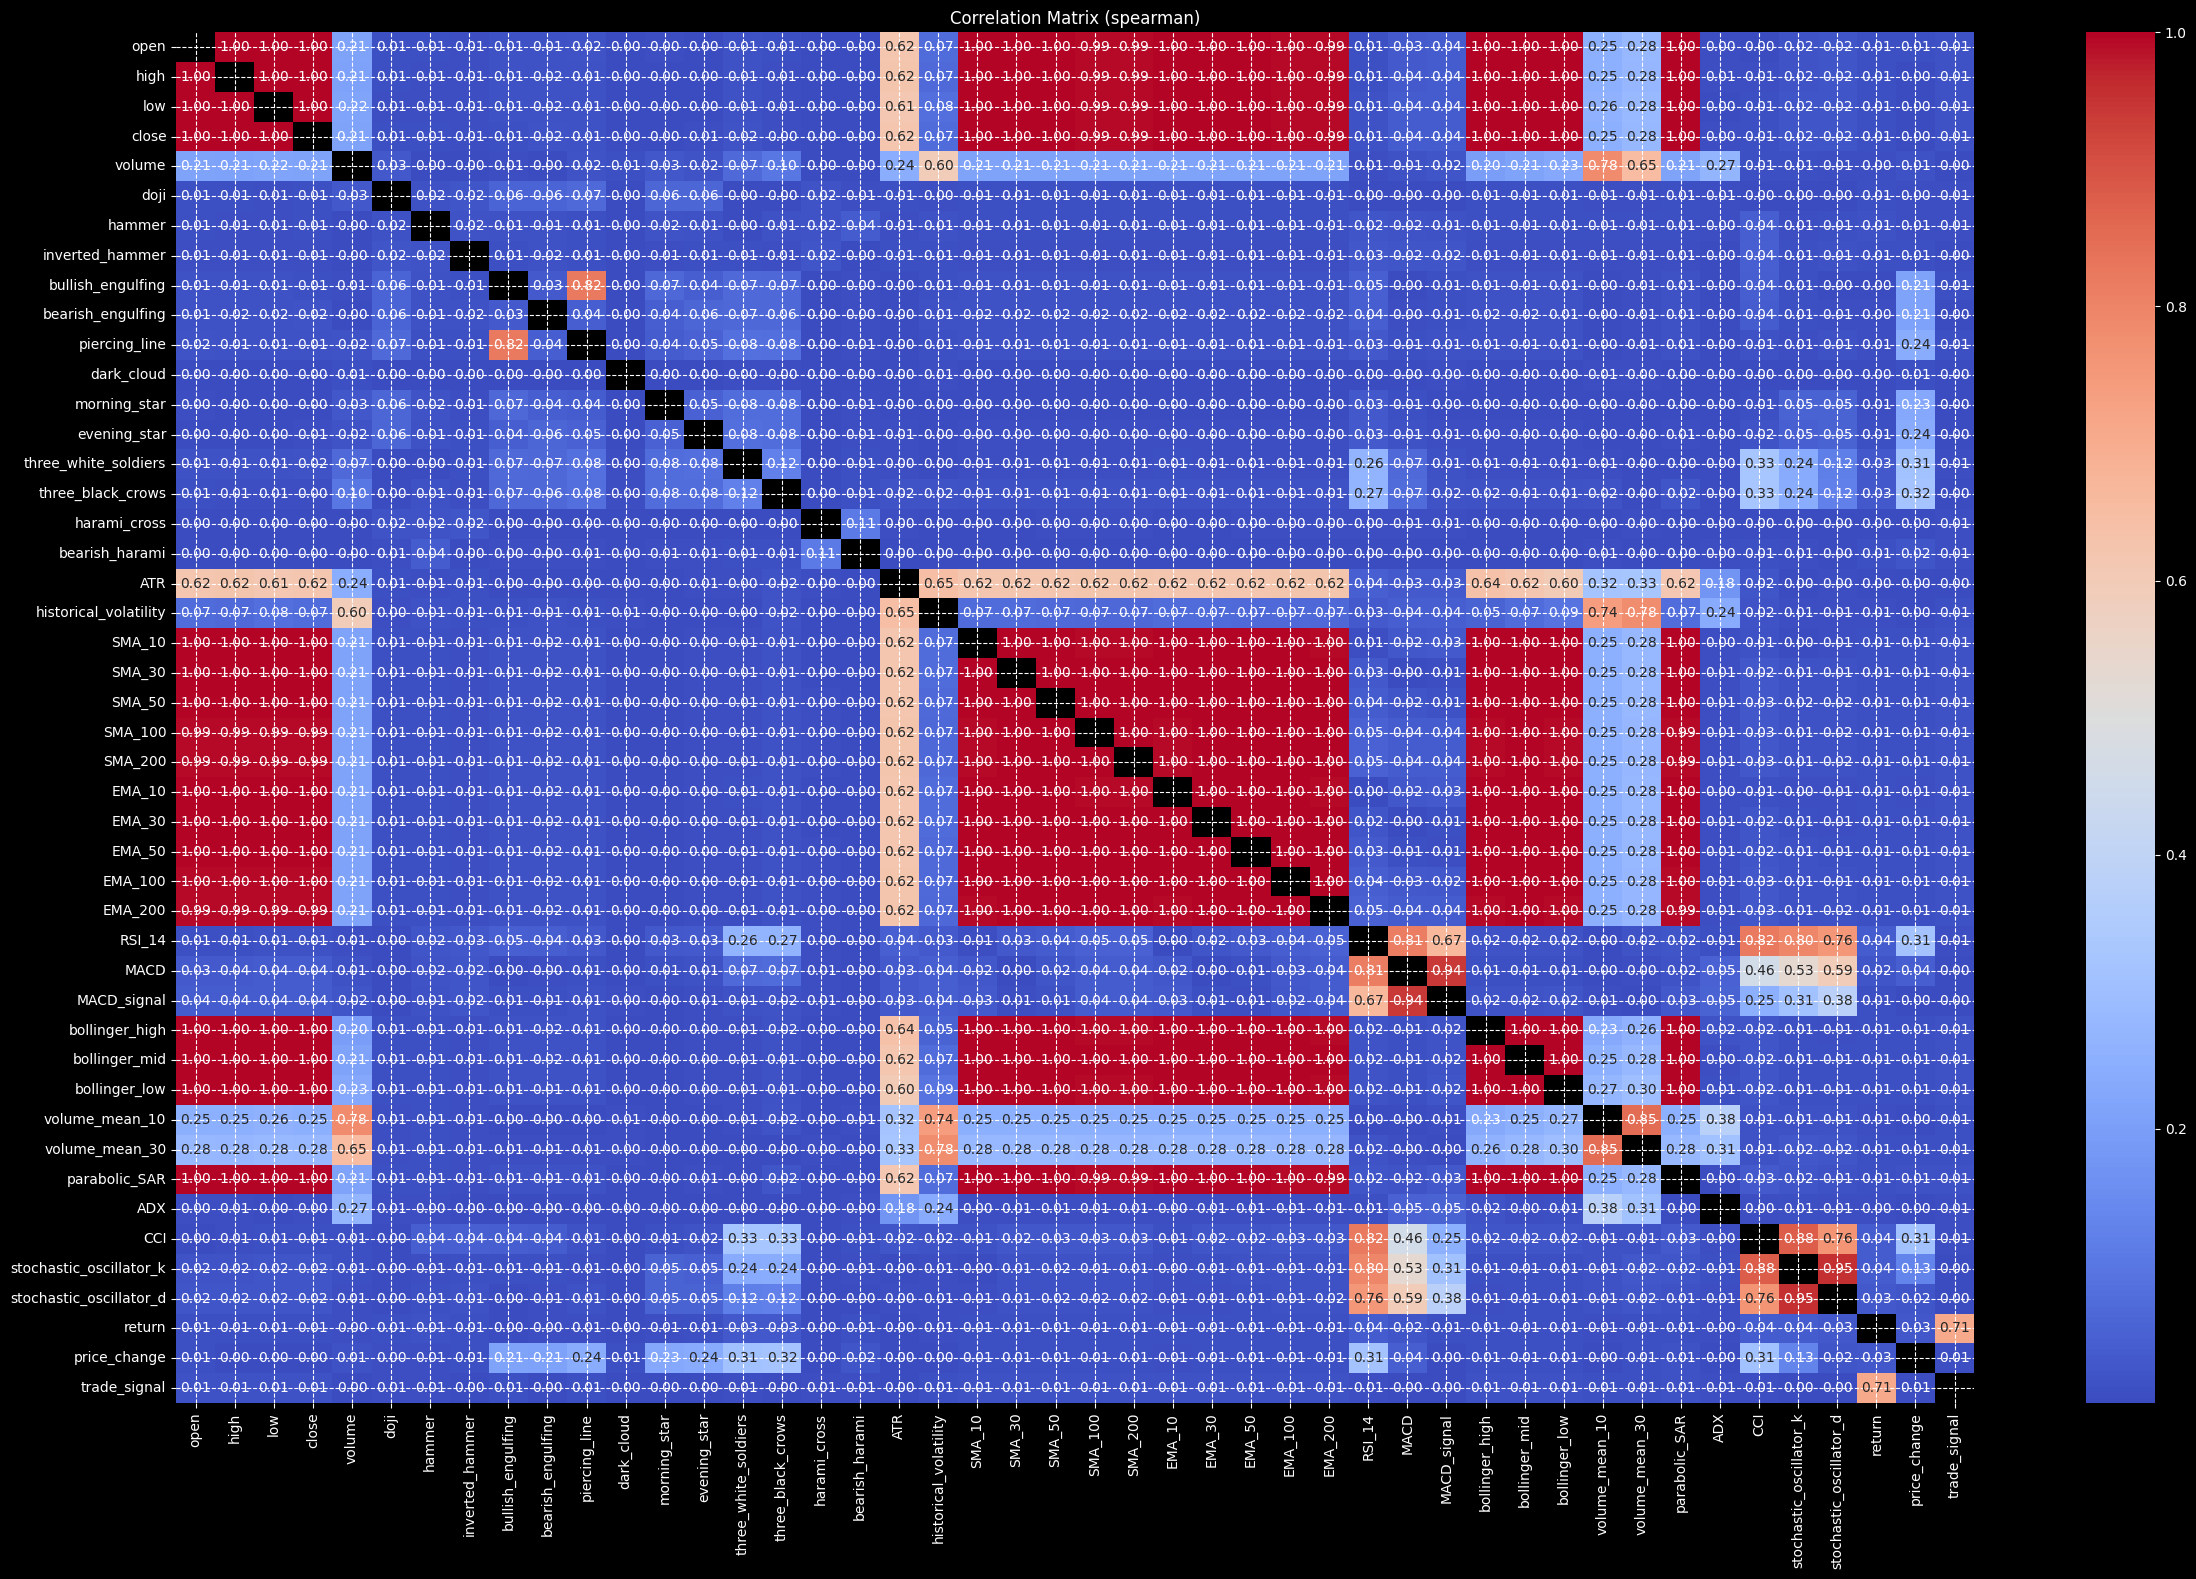


Multicollinearity Table (spearman)


Feature 1                Feature 2  Correlation
98                   SMA_100                  SMA_200     1.000000
112                  SMA_200                  EMA_200     1.000000
103                  SMA_100                  EMA_200     1.000000
66                    SMA_10                   EMA_10     0.999969
79                    SMA_30                   EMA_30     0.999914
..                       ...                      ...          ...
43                       low                  EMA_200     0.994377
37                       low                  SMA_100     0.994377
38                       low                  SMA_200     0.994377
154  stochastic_oscillator_k  stochastic_oscillator_d     0.954304
147                     MACD              MACD_signal     0.943154

[155 rows x 3 columns]

In [61]:
find_multicollinearity(df_stationary, methods=['spearman'], threshold=0.9)

## Data splitting

In [62]:
df = df_stationary.copy()

In [63]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 70075 entries, 2023-09-02 01:00:00+00:00 to 2025-08-31 23:30:00+00:00
Data columns (total 46 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   open                     70075 non-null  float64
 1   high                     70075 non-null  float64
 2   low                      70075 non-null  float64
 3   close                    70075 non-null  float64
 4   volume                   70075 non-null  float64
 5   doji                     70075 non-null  bool   
 6   hammer                   70075 non-null  bool   
 7   inverted_hammer          70075 non-null  bool   
 8   bullish_engulfing        70075 non-null  bool   
 9   bearish_engulfing        70075 non-null  bool   
 10  piercing_line            70075 non-null  bool   
 11  dark_cloud               70075 non-null  bool   
 12  morning_star             70075 non-null  bool   
 13  evening_star             7007

In [64]:
df.columns

Index(['open', 'high', 'low', 'close', 'volume', 'doji', 'hammer',
       'inverted_hammer', 'bullish_engulfing', 'bearish_engulfing',
       'piercing_line', 'dark_cloud', 'morning_star', 'evening_star',
       'three_white_soldiers', 'three_black_crows', 'harami_cross',
       'bearish_harami', 'ATR', 'historical_volatility', 'SMA_10', 'SMA_30',
       'SMA_50', 'SMA_100', 'SMA_200', 'EMA_10', 'EMA_30', 'EMA_50', 'EMA_100',
       'EMA_200', 'RSI_14', 'MACD', 'MACD_signal', 'bollinger_high',
       'bollinger_mid', 'bollinger_low', 'volume_mean_10', 'volume_mean_30',
       'parabolic_SAR', 'ADX', 'CCI', 'stochastic_oscillator_k',
       'stochastic_oscillator_d', 'return', 'price_change', 'trade_signal'],
      dtype='object')

In [65]:
# Split Target from Featureset

# X = df.iloc[:, :-1] # all rows and all columns are selected except the last column ["TARGET"].
# y = df.iloc[:, -1] # select the last column ["TARGET"]


# X = df.drop(columns=["trade_signal", "return", "SMA_200", "EMA_200", "price_change", "EMA_50", "stochastic_oscillator_d", "MACD_signal"])

X = df.drop(columns=['three_black_crows', 'harami_cross',
       'bearish_harami', 'ATR', 'historical_volatility', 'SMA_10', 'SMA_30',
       'SMA_50', 'SMA_100', 'SMA_200', 'EMA_10', 'EMA_30', 'EMA_50', 'EMA_100',
       'EMA_200', 'RSI_14', 'MACD', 'MACD_signal', 'bollinger_high',
       'bollinger_mid', 'bollinger_low', 'volume_mean_10', 'volume_mean_30',
       'parabolic_SAR', 'ADX', 'CCI', 'stochastic_oscillator_k',
       'stochastic_oscillator_d', 'return', 'price_change', 'trade_signal'])

y = df["trade_signal"]

X = X.astype({col: int for col in X.select_dtypes(include=bool).columns})

In [66]:
# split time series: train 80%, test 20%

train_size = int(len(X) * 0.8)

X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

print("Train start:", X_train.index.min())
print("Train end:  ", X_train.index.max())
print("Test start: ", X_test.index.min())
print("Test end:   ", X_test.index.max())

Train start: 2023-09-02 01:00:00+00:00
Train end:   2025-04-07 23:45:00+00:00
Test start:  2025-04-08 00:00:00+00:00
Test end:    2025-08-31 23:30:00+00:00


In [67]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled

array([[-2.69697676, -2.69954976, -2.69432196, ...,  4.59030131,
        -0.22044333, -0.35521501],
       [-2.69495489, -2.6966013 , -2.69042883, ..., -0.21785062,
        -0.22044333,  2.81519633],
       [-2.692315  , -2.69574888, -2.69042883, ..., -0.21785062,
        -0.22044333, -0.35521501],
       ...,
       [-0.10453737, -0.10834989, -0.10700495, ..., -0.21785062,
        -0.22044333, -0.35521501],
       [-0.10942957, -0.11281711, -0.11982862, ..., -0.21785062,
        -0.22044333, -0.35521501],
       [-0.12236524, -0.12108838, -0.11912118, ..., -0.21785062,
        -0.22044333, -0.35521501]])

In [68]:
print("Train shape:", X_train_scaled.shape, y_train.shape)
print("Test shape:", X_test_scaled.shape, y_test.shape)

Train shape: (56060, 15) (56060,)
Test shape: (14015, 15) (14015,)


In [69]:
X_train_scaled

array([[-2.69697676, -2.69954976, -2.69432196, ...,  4.59030131,
        -0.22044333, -0.35521501],
       [-2.69495489, -2.6966013 , -2.69042883, ..., -0.21785062,
        -0.22044333,  2.81519633],
       [-2.692315  , -2.69574888, -2.69042883, ..., -0.21785062,
        -0.22044333, -0.35521501],
       ...,
       [-0.10453737, -0.10834989, -0.10700495, ..., -0.21785062,
        -0.22044333, -0.35521501],
       [-0.10942957, -0.11281711, -0.11982862, ..., -0.21785062,
        -0.22044333, -0.35521501],
       [-0.12236524, -0.12108838, -0.11912118, ..., -0.21785062,
        -0.22044333, -0.35521501]])

## Train and evaluation

In [70]:
from sklearn.utils import compute_class_weight
import numpy as np

classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
weights_dict = dict(zip(classes, class_weights))

In [71]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix

# Перекодируем: -1 -> 0, 0 -> 1, 1 -> 2
y_train_enc = np.where(y_train == -1, 0,
                       np.where(y_train == 0, 1, 2))
y_test_enc = np.where(y_test == -1, 0,
                      np.where(y_test == 0, 1, 2))

model = xgb.XGBClassifier(
    objective="multi:softprob",
    num_class=3,
    eval_metric="mlogloss",
    random_state=42,

    # ключевые ограничения
    max_depth=3,          # глубина деревьев (3–6 нормально)
    min_child_weight=5,   # минимальное число выборок в листе
    subsample=0.7,        # доля выборки для каждого дерева
    colsample_bytree=0.7, # доля признаков для каждого дерева

    # регуляризация
    reg_alpha=0.1,        # L1
    reg_lambda=1.0,       # L2

    n_estimators=500,     # количество деревьев (побольше)
    learning_rate=0.05    # и поменьше шаг обучения
)


sample_weights = y_train.map(weights_dict)

model.fit(X_train, y_train_enc, sample_weight=sample_weights)

y_train_pred_enc = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)

y_train_pred = np.where(y_train_pred_enc == 0, -1,
                        np.where(y_train_pred_enc == 1, 0, 1))

# Предсказания
y_pred_enc = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

# Обратно в исходные классы (-1, 0, 1)
y_pred = np.where(y_pred_enc == 0, -1,
                  np.where(y_pred_enc == 1, 0, 1))



Train accuracy: 0.5846236175526222
Test accuracy: 0.4954691402069212

Classification Report (Train):
              precision    recall  f1-score   support

          -1       0.22      0.44      0.29      6224
           0       0.88      0.63      0.73     43528
           1       0.22      0.43      0.29      6308

    accuracy                           0.58     56060
   macro avg       0.44      0.50      0.44     56060
weighted avg       0.73      0.58      0.63     56060


Classification Report (Test):
              precision    recall  f1-score   support

          -1       0.10      0.40      0.16      1063
           0       0.92      0.52      0.66     11903
           1       0.11      0.32      0.16      1049

    accuracy                           0.50     14015
   macro avg       0.38      0.41      0.33     14015
weighted avg       0.79      0.50      0.59     14015



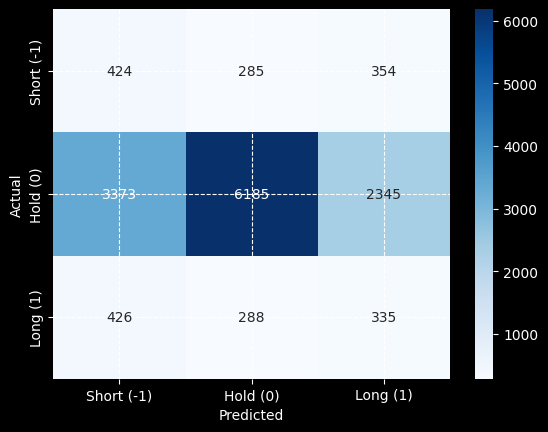

In [72]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# --- Accuracy ---
print("Train accuracy:", accuracy_score(y_train_enc, model.predict(X_train)))
print("Test accuracy:", accuracy_score(y_test_enc, model.predict(X_test)))


# --- Classification report ---
print("\nClassification Report (Train):")
print(classification_report(y_train, y_train_pred))  # здесь используем исходные классы [-1,0,1]


# --- Classification report ---
print("\nClassification Report (Test):")
print(classification_report(y_test, y_pred))  # здесь используем исходные классы [-1,0,1]

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred, labels=[-1,0,1])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Short (-1)", "Hold (0)", "Long (1)"],
            yticklabels=["Short (-1)", "Hold (0)", "Long (1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## Backtest

In [73]:
! pip install backtrader
import backtrader as bt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.5/419.5 kB 8.4 MB/s eta 0:00:00


In [74]:
# Creating a Dataframe with test data and predictions

test_data = data.loc[X_test.index].copy()
test_data['predictions'] = y_pred

# Converting data to backtrader format
class CustomPandasData(bt.feeds.PandasData):
    lines = ('predictions',)
    params = (
        ('predictions', -1),
        ('datetime', None),
        ('open', 'open'),
        ('high', 'high'),
        ('low', 'low'),
        ('close', 'close'),
        ('volume', 'volume'),
        ('openinterest', None),
    )

In [75]:
class MLStrategy(bt.Strategy):
    params = (
        ('stop_loss', 0.01), # 1% stop loss
        ('take_profit', 0.1), # 10% take profit
        ('stake', 1000) # position size in dollars
    )

    def __init__(self):
        self.dataclose = self.datas[0].close
        self.predictions = self.datas[0].predictions
        self.order = None # checking for existing order
        self.price = None
        self.stop_price = None
        self.take_profit_price = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return # orders sent / accepted by broker

        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f"BUY EXECUTED, Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Comm: {order.executed.comm:.2f}")
                self.price = order.executed.price
                self.stop_price = self.price * (1.0 - self.params.stop_loss)
                self.take_profit_price = self.price * (1.0 + self.params.take_profit)
            elif order.issell():
                self.log(f"SELL EXECUTED, Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Comm: {order.executed.comm:.2f}")
            self.order = None

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
            self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        self.log(f'OPERATION PROFIT, GROSS {trade.pnl:.2f}, NET {trade.pnlcomm:.2f}')

    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print(f'{dt.isoformat()} {txt}')

    def next(self):
        if self.order:
            return

        if not self.position:
            if self.predictions[0] > 0:
                self.order = self.buy(size=self.params.stake / self.dataclose[0])
                self.log(f'BUY CREATED, Price: {self.dataclose[0]:.2f}')

        else:
            if self.dataclose[0] <= self.stop_price or self.dataclose[0] >= self.take_profit_price:
                self.order = self.sell(size=self.position.size)
                self.log(f'SELL CREATED, Price: {self.dataclose[0]:.2f}')

        # Output current portfolio value for debugging
        self.log(f'Position Value: {self.broker.getvalue():.2f}')

In [76]:
# Create Cerebro and add data and strategy
cerebro = bt.Cerebro()
cerebro.addstrategy(MLStrategy)


# Convert data to backtrader format
datafeed = CustomPandasData(dataname=test_data)
cerebro.adddata(datafeed)

# Add Observer to track profile cost
cerebro.addobserver(bt.observers.Value)

# Initial funds
cerebro.broker.set_cash(10000.0)

# Set Commision
cerebro.broker.setcommission(commission=0.001)


# Run backtest
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
strategies = cerebro.run()
print('Ending Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Getting profile values ​​and dates from Observer
portfolio_values = [ob for ob in strategies[0].observers if isinstance(ob, bt.observers.Value)][0].lines.value.get(0, size=len(test_data))
portfolio_dates = test_data.index[:len(portfolio_values)]

Streaming output truncated to the last 5000 lines.
2025-07-13 Position Value: 10405.47
2025-07-13 Position Value: 10412.20
2025-07-13 Position Value: 10411.51
2025-07-13 Position Value: 10408.05
2025-07-13 Position Value: 10408.49
2025-07-13 Position Value: 10409.50
2025-07-13 Position Value: 10411.32
2025-07-13 Position Value: 10411.89
2025-07-13 Position Value: 10409.88
2025-07-13 Position Value: 10407.42
2025-07-13 Position Value: 10409.37
2025-07-13 Position Value: 10411.32
2025-07-13 Position Value: 10407.86
2025-07-13 Position Value: 10408.99
2025-07-13 Position Value: 10409.75
2025-07-13 Position Value: 10410.00
2025-07-13 Position Value: 10411.07
2025-07-13 Position Value: 10413.09
2025-07-13 Position Value: 10413.59
2025-07-13 Position Value: 10414.78
2025-07-13 Position Value: 10414.34
2025-07-13 Position Value: 10415.04
2025-07-13 Position Value: 10413.59
2025-07-13 Position Value: 10410.88
2025-07-13 Position Value: 10412.52
2025-07-13 Position Value: 10413.71
2025-07-13 Po

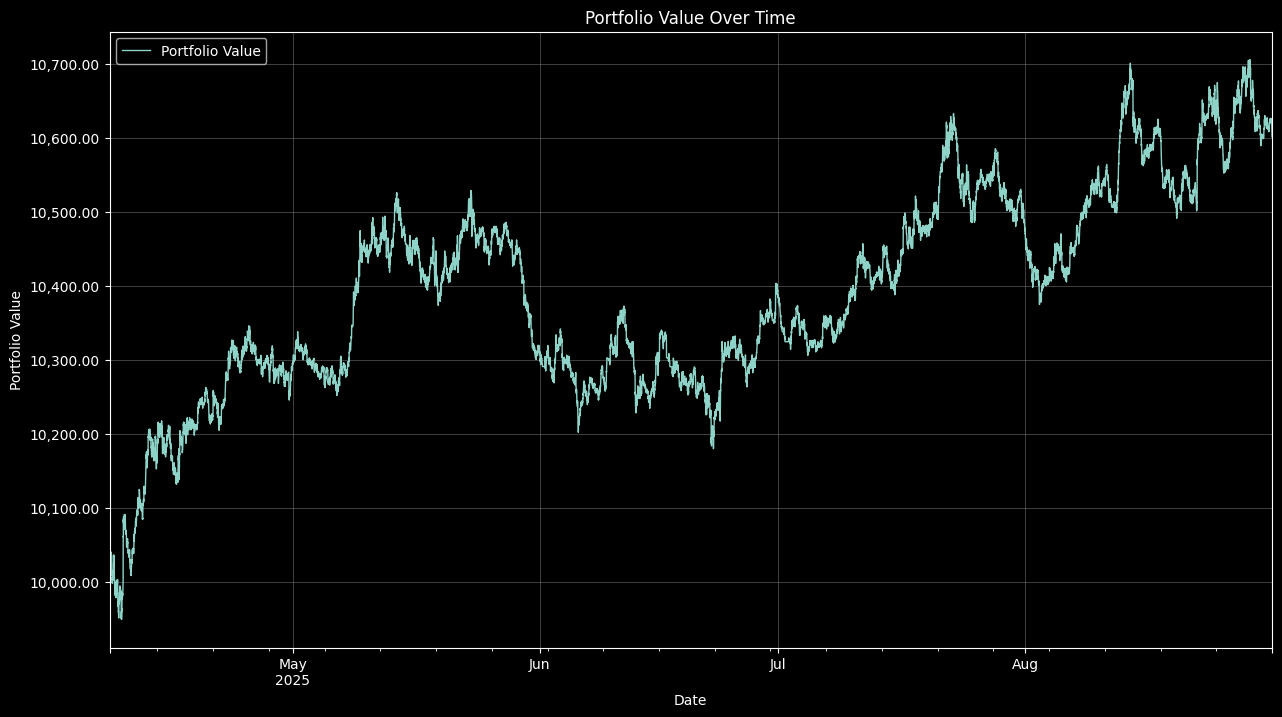

In [77]:
# Creating a Dataframe with portfolio values and predictions

portfolio_df = pd.DataFrame({'Date': portfolio_dates, 'portfolio_value': portfolio_values})
portfolio_df.set_index('Date', inplace=True)

%matplotlib inline
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(15, 8))
portfolio_df['portfolio_value'].plot(label='Portfolio Value')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.title('Portfolio Value Over Time')
plt.grid(color='grey', linestyle='-', linewidth=0.5, alpha=0.7)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:,.2f}'.format(x)))
plt.legend()
plt.show()

## Log profobility

log_return = log(close t+1 / close t) - логорифм от часовой доходности 4:30